In [1]:
# ===== Cell 1: 載入必要套件 =====
import pandas as pd
import numpy as np
import glob
import os

# ===== Cell 2: 快速載入器 =====
class QuickLoader:
    """簡化版載入器，直接產生 arduino_features"""
    
    def __init__(self, data_dir='data/raw'):
        self.data_dir = data_dir
        self.sensor_cols = ['MQ2_raw', 'MQ3_raw', 'MQ9_raw', 'MQ135_raw', 'TGS2602_raw']
        
        # R0 校正參考值
        self.R0_reference = {
            'MQ2_raw': 10.0,
            'MQ3_raw': 60.0,
            'MQ9_raw': 9.8,
            'MQ135_raw': 76.63,
            'TGS2602_raw': 2.5
        }
    
    def load_and_process(self):
        """一次性載入並處理到 arduino_features"""
        print("🔧 快速處理模式...")
        
        # 1. 載入所有檔案
        air_data, pineapple_data = self._load_files()
        
        if not pineapple_data:
            print("❌ 找不到鳳梨數據")
            return None
        
        # 2. 計算 Arduino 特徵
        arduino_features = self._calculate_features(air_data, pineapple_data)
        
        print(f"✅ 完成！產生 {len(arduino_features)} 顆鳳梨的特徵")
        return arduino_features
    
    def _load_files(self):
        """載入 Excel 檔案"""
        xlsx_files = glob.glob(os.path.join(self.data_dir, '*.xlsx'))
        print(f"📂 找到 {len(xlsx_files)} 個檔案")
        
        air_data = {}
        pineapple_data = {}
        
        for file_path in xlsx_files:
            filename = os.path.basename(file_path)
            parts = filename.replace('.xlsx', '').split('_')
            
            if len(parts) < 3:
                continue
            
            is_air = 'air' in filename
            
            # 讀取檔案
            try:
                # 嘗試跳過第一行
                df = pd.read_excel(file_path, engine='openpyxl', skiprows=1)
                
                # 檢查是否有正確的欄位
                if 'timestamp_ms' not in df.columns:
                    df = pd.read_excel(file_path, engine='openpyxl')
                
                # 轉換數字型別
                for col in self.sensor_cols + ['timestamp_ms']:
                    if col in df.columns:
                        df[col] = pd.to_numeric(df[col], errors='coerce')
                
                # 清理缺值
                df = df.dropna().reset_index(drop=True)
                
            except Exception as e:
                print(f"⚠️  載入失敗 {filename}: {e}")
                continue
            
            # 分類儲存
            if is_air:
                if len(parts) == 3:
                    # 共用 air
                    date = parts[1]
                    air_data[f"shared_{date}"] = df
                else:
                    # 專屬 air
                    pid = parts[1]
                    date = parts[2]
                    air_data[f"{pid}_{date}"] = df
            else:
                pid = parts[1]
                date = parts[2]
                
                if pid not in pineapple_data:
                    pineapple_data[pid] = {}
                pineapple_data[pid][date] = df
        
        print(f"   ✓ Air: {len(air_data)}, Pineapple: {len(pineapple_data)} 顆")
        return air_data, pineapple_data
    
    def _calculate_features(self, air_data, pineapple_data):
        """計算 Arduino 特徵"""
        arduino_features = {}
        
        for pid, date_dict in pineapple_data.items():
            arduino_features[pid] = {}
            
            for date, pine_df in date_dict.items():
                # 找對應的 air baseline
                air_df = self._get_air(air_data, pid, date)
                
                if air_df is None:
                    print(f"⚠️  {pid}_{date} 找不到 air baseline")
                    continue
                
                # 計算 Delta
                min_len = min(len(pine_df), len(air_df))
                delta_df = pine_df.iloc[:min_len].copy()
                
                for col in self.sensor_cols:
                    if col in pine_df.columns and col in air_df.columns:
                        delta_df[f'{col}_delta'] = (
                            pine_df[col].iloc[:min_len].values - 
                            air_df[col].iloc[:min_len].values
                        )
                
                # 計算 Arduino 特徵
                features_df = delta_df.copy()
                
                for col in self.sensor_cols:
                    if col in delta_df.columns:
                        sensor_name = col.replace('_raw', '')
                        R0 = self.R0_reference.get(col, 10.0)
                        
                        # Rs/R0
                        features_df[f'{sensor_name}_Rs_R0'] = delta_df[col] / R0
                        
                        # Delta Rs/R0
                        delta_col = f'{col}_delta'
                        if delta_col in delta_df.columns:
                            features_df[f'{sensor_name}_delta_Rs_R0'] = delta_df[delta_col] / R0
                        
                        # 移動平均
                        features_df[f'{sensor_name}_ma10'] = (
                            delta_df[col].rolling(window=10, center=True).mean()
                        )
                        
                        # 移動標準差
                        features_df[f'{sensor_name}_std10'] = (
                            delta_df[col].rolling(window=10, center=True).std()
                        )
                
                arduino_features[pid][date] = features_df
                print(f"   ✓ {pid}_{date}: {features_df.shape}")
        
        return arduino_features
    
    def _get_air(self, air_data, pid, date):
        """取得對應的 air baseline"""
        # 專屬 air
        key = f"{pid}_{date}"
        if key in air_data:
            return air_data[key]
        
        # 共用 air
        shared_key = f"shared_{date}"
        if shared_key in air_data:
            return air_data[shared_key]
        
        return None

# 執行載入
loader = QuickLoader('data/raw')
arduino_features = loader.load_and_process()


🔧 快速處理模式...
📂 找到 54 個檔案
   ✓ Air: 25, Pineapple: 8 顆
   ✓ 07_20250203: (900, 50)
   ✓ 07_20250205: (899, 50)
   ✓ 07_20250204: (900, 50)
   ✓ 08_20250204: (900, 50)
   ✓ 08_20250203: (900, 50)
   ✓ 08_20250205: (900, 50)
   ✓ 02_20250202: (900, 50)
   ✓ 02_20250203: (900, 50)
   ✓ 02_20250205: (900, 50)
   ✓ 02_20250204: (900, 50)
   ✓ 06_20250205: (0, 74)
   ✓ 06_20250204: (900, 50)
⚠️  06_20250202 找不到 air baseline
   ✓ 06_20250203: (900, 50)
   ✓ 04_20250205: (899, 54)
   ✓ 04_20250203: (900, 50)
   ✓ 04_20250204: (900, 54)
   ✓ 03_20250204: (900, 54)
   ✓ 03_20250205: (900, 54)
   ✓ 03_20250203: (900, 50)
   ✓ 01_20250202: (900, 50)
   ✓ 01_20250201: (900, 50)
   ✓ 01_20250203: (900, 50)
   ✓ 01_20250204: (900, 50)
   ✓ 01_20250205: (900, 50)
   ✓ 05_20250203: (900, 50)
   ✓ 05_20250204: (900, 50)
   ✓ 05_20250205: (900, 50)
   ✓ 05_20250202: (900, 50)
✅ 完成！產生 8 顆鳳梨的特徵


In [2]:
# 快速檢查
import os
files_to_check = [
    'data/processed/feature_data.pkl',
    'data/processed/feature_matrix.csv',
    'data/processed/labels.npy'
]

for file in files_to_check:
    if os.path.exists(file):
        print(f"✅ {file}")
    else:
        print(f"❌ {file} 不存在！")


✅ data/processed/feature_data.pkl
✅ data/processed/feature_matrix.csv
✅ data/processed/labels.npy


In [4]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 156.8 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7

[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [6]:
!pip install matplotlib seaborn scikit-learn pandas numpy


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [7]:
# ===== Cell 12: Step 5 - 模型訓練與比較 =====

import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

class ModelTrainer:
    """
    訓練並比較多個分類模型
    主模型：SVM (RBF kernel)
    對比模型：Random Forest
    """
    
    def __init__(self, X, y, metadata):
        self.X = X
        self.y = y
        self.metadata = metadata
        
        # 標準化特徵
        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(X)
        
        # 模型
        self.svm_model = None
        self.rf_model = None
        
        # 結果
        self.results = {}
        
        self.output_dir = 'models'
        os.makedirs(self.output_dir, exist_ok=True)
    
    def train_and_evaluate_all(self):
        """訓練並評估所有模型"""
        print("="*60)
        print("🤖 Step 5: 模型訓練與比較")
        print("="*60)
        
        # 1. SVM (主模型)
        print("\n📊 訓練 SVM (RBF kernel)...")
        self._train_svm()
        
        # 2. Random Forest (對比)
        print("\n📊 訓練 Random Forest...")
        self._train_random_forest()
        
        # 3. 比較結果
        print("\n📊 模型比較...")
        self._compare_models()
        
        # 4. 特徵重要性分析
        print("\n📊 特徵重要性分析...")
        self._analyze_feature_importance()
        
        # 5. 錯誤案例分析
        print("\n📊 錯誤案例分析...")
        self._analyze_errors()
        
        # 6. 儲存模型
        print("\n💾 儲存模型...")
        self._save_models()
        
        print("\n" + "="*60)
        print("✅ Step 5 完成！")
        print("="*60)
    
    def _train_svm(self):
        """訓練 SVM 模型"""
        # 使用不同的 C 和 gamma 參數
        param_grid = [
            {'C': 1, 'gamma': 'scale'},
            {'C': 10, 'gamma': 'scale'},
            {'C': 100, 'gamma': 'scale'},
            {'C': 1, 'gamma': 'auto'},
        ]
        
        best_score = 0
        best_params = None
        
        for params in param_grid:
            svm = SVC(kernel='rbf', **params, random_state=42)
            
            # 5-fold 交叉驗證
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(svm, self.X_scaled, self.y, cv=cv, scoring='accuracy')
            mean_score = scores.mean()
            
            print(f"   C={params['C']}, gamma={params['gamma']}: {mean_score:.3f} (+/- {scores.std():.3f})")
            
            if mean_score > best_score:
                best_score = mean_score
                best_params = params
        
        print(f"\n   ✅ 最佳參數: {best_params}")
        print(f"   ✅ 交叉驗證準確率: {best_score:.3f}")
        
        # 用最佳參數訓練最終模型
        self.svm_model = SVC(kernel='rbf', **best_params, random_state=42)
        self.svm_model.fit(self.X_scaled, self.y)
        
        # 交叉驗證預測（用於混淆矩陣）
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        y_pred_cv = cross_val_predict(self.svm_model, self.X_scaled, self.y, cv=cv)
        
        self.results['svm'] = {
            'model': self.svm_model,
            'cv_score': best_score,
            'y_pred_cv': y_pred_cv,
            'params': best_params
        }
    
    def _train_random_forest(self):
        """訓練 Random Forest 模型"""
        # 嘗試不同的參數
        param_grid = [
            {'n_estimators': 100, 'max_depth': None},
            {'n_estimators': 200, 'max_depth': 10},
            {'n_estimators': 100, 'max_depth': 5},
        ]
        
        best_score = 0
        best_params = None
        
        for params in param_grid:
            rf = RandomForestClassifier(**params, random_state=42)
            
            # 5-fold 交叉驗證
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(rf, self.X_scaled, self.y, cv=cv, scoring='accuracy')
            mean_score = scores.mean()
            
            print(f"   n_est={params['n_estimators']}, depth={params['max_depth']}: {mean_score:.3f} (+/- {scores.std():.3f})")
            
            if mean_score > best_score:
                best_score = mean_score
                best_params = params
        
        print(f"\n   ✅ 最佳參數: {best_params}")
        print(f"   ✅ 交叉驗證準確率: {best_score:.3f}")
        
        # 用最佳參數訓練最終模型
        self.rf_model = RandomForestClassifier(**best_params, random_state=42)
        self.rf_model.fit(self.X_scaled, self.y)
        
        # 交叉驗證預測
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        y_pred_cv = cross_val_predict(self.rf_model, self.X_scaled, self.y, cv=cv)
        
        self.results['rf'] = {
            'model': self.rf_model,
            'cv_score': best_score,
            'y_pred_cv': y_pred_cv,
            'params': best_params
        }
    
    def _compare_models(self):
        """比較模型表現"""
        print("\n" + "="*60)
        print("📊 模型比較結果")
        print("="*60)
        
        for model_name, result in self.results.items():
            model_display = "SVM (RBF)" if model_name == 'svm' else "Random Forest"
            print(f"\n🤖 {model_display}")
            print(f"   交叉驗證準確率: {result['cv_score']:.3f}")
            
            # 分類報告
            y_pred = result['y_pred_cv']
            print("\n   分類報告:")
            report = classification_report(self.y, y_pred, 
                                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                                          digits=3)
            print("   " + report.replace("\n", "\n   "))
            
            # 混淆矩陣
            cm = confusion_matrix(self.y, y_pred)
            print(f"\n   混淆矩陣:")
            print(f"   {cm}")
        
        # 推薦模型
        best_model = max(self.results.items(), key=lambda x: x[1]['cv_score'])
        print(f"\n✅ 推薦模型: {'SVM (RBF)' if best_model[0] == 'svm' else 'Random Forest'}")
        print(f"   準確率: {best_model[1]['cv_score']:.3f}")
    
    def _analyze_feature_importance(self):
        """分析特徵重要性（Random Forest）"""
        if 'rf' not in self.results:
            return
        
        rf_model = self.results['rf']['model']
        feature_names = self.X.columns if hasattr(self.X, 'columns') else [f'F{i}' for i in range(self.X.shape[1])]
        
        # 取得特徵重要性
        importances = rf_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        print("\n🔝 Top 10 重要特徵 (Random Forest):")
        for i, idx in enumerate(indices[:10], 1):
            print(f"   {i:2d}. {feature_names[idx]:30s}: {importances[idx]:.4f}")
        
        # 儲存完整特徵重要性
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        csv_path = os.path.join(self.output_dir, 'feature_importance.csv')
        importance_df.to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"\n   💾 完整特徵重要性: {csv_path}")
    
    def _analyze_errors(self):
        """分析錯誤案例"""
        print("\n❌ 錯誤案例分析 (SVM):")
        
        if 'svm' not in self.results:
            return
        
        y_pred = self.results['svm']['y_pred_cv']
        errors = self.y != y_pred
        
        print(f"   錯誤樣本數: {errors.sum()} / {len(self.y)} ({errors.sum()/len(self.y)*100:.1f}%)")
        
        # 分析哪些類別容易混淆
        error_pairs = []
        for true_label, pred_label in zip(self.y[errors], y_pred[errors]):
            error_pairs.append((int(true_label), int(pred_label)))
        
        from collections import Counter
        error_counts = Counter(error_pairs)
        
        print("\n   最常見的混淆 (真實 → 預測):")
        for (true_l, pred_l), count in error_counts.most_common(5):
            print(f"      Stage {true_l} → Stage {pred_l}: {count} 次")
        
        # 儲存錯誤案例
        error_df = self.metadata[errors].copy()
        error_df['true_label'] = self.y[errors]
        error_df['predicted_label'] = y_pred[errors]
        
        csv_path = os.path.join(self.output_dir, 'error_cases.csv')
        error_df.to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"\n   💾 錯誤案例詳情: {csv_path}")
    
    def _save_models(self):
        """儲存訓練好的模型"""
        # 儲存 SVM
        if 'svm' in self.results:
            svm_path = os.path.join(self.output_dir, 'svm_model.pkl')
            with open(svm_path, 'wb') as f:
                pickle.dump({
                    'model': self.results['svm']['model'],
                    'scaler': self.scaler,
                    'params': self.results['svm']['params'],
                    'cv_score': self.results['svm']['cv_score']
                }, f)
            print(f"   ✅ SVM: {svm_path}")
        
        # 儲存 Random Forest
        if 'rf' in self.results:
            rf_path = os.path.join(self.output_dir, 'rf_model.pkl')
            with open(rf_path, 'wb') as f:
                pickle.dump({
                    'model': self.results['rf']['model'],
                    'scaler': self.scaler,
                    'params': self.results['rf']['params'],
                    'cv_score': self.results['rf']['cv_score']
                }, f)
            print(f"   ✅ Random Forest: {rf_path}")
        
        print("\n✅ 模型已儲存，可以進入 Step 6（部署）")

# 載入特徵
with open('data/processed/feature_data.pkl', 'rb') as f:
    data = pickle.load(f)

X = data['features']
y = data['labels']
metadata = data['metadata']

# 訓練模型
trainer = ModelTrainer(X, y, metadata)
trainer.train_and_evaluate_all()


🤖 Step 5: 模型訓練與比較

📊 訓練 SVM (RBF kernel)...
   C=1, gamma=scale: 0.495 (+/- 0.094)
   C=10, gamma=scale: 0.915 (+/- 0.049)
   C=100, gamma=scale: 0.920 (+/- 0.040)
   C=1, gamma=auto: 0.495 (+/- 0.094)

   ✅ 最佳參數: {'C': 100, 'gamma': 'scale'}
   ✅ 交叉驗證準確率: 0.920

📊 訓練 Random Forest...
   n_est=100, depth=None: 0.935 (+/- 0.025)
   n_est=200, depth=10: 0.945 (+/- 0.040)
   n_est=100, depth=5: 0.910 (+/- 0.025)

   ✅ 最佳參數: {'n_estimators': 200, 'max_depth': 10}
   ✅ 交叉驗證準確率: 0.945

📊 模型比較...

📊 模型比較結果

🤖 SVM (RBF)
   交叉驗證準確率: 0.920

   分類報告:
                 precision    recall  f1-score   support
   
        Stage 0      0.928     0.941     0.934        68
        Stage 1      0.894     0.913     0.903        46
        Stage 2      0.886     0.861     0.873        36
        Stage 3      0.959     0.940     0.949        50
   
       accuracy                          0.920       200
      macro avg      0.917     0.914     0.915       200
   weighted avg      0.920     0.920     0.920 

In [9]:
# 以下為嘗試調整改進

In [ ]:
#📊 實驗 1：類別權重調整
#測試 3 種策略：

#None（基準）

#Balanced（自動平衡）

#Custom（強化 Stage 2，給 1.5 倍權重）

#📊 實驗 2：不同窗口大小
#測試 4 種窗口：

#60 秒：更細緻，樣本更多

#120 秒：當前基準

#180 秒：更穩定

#240 秒：最穩定但樣本較少

#📊 實驗 3：特徵選擇
#測試使用 10, 20, 30, 40, 53 個特徵的效果

🔬 模型改進實驗
基準模型: Random Forest, 準確率 = 0.945

📊 實驗 1: 類別權重調整
----------------------------------------------------------------------
➡️ None (基準)                : 準確率=0.945 (+0.000)
   ✅ Stage 2 Recall: 0.861 (基準=0.861)
📉 Balanced                 : 準確率=0.935 (-0.010)
   ⚠️ Stage 2 Recall: 0.806 (基準=0.861)
📉 Custom (強化Stage2)        : 準確率=0.935 (-0.010)
   ⚠️ Stage 2 Recall: 0.833 (基準=0.861)

📊 實驗 2: 不同窗口大小
----------------------------------------------------------------------

🔍 測試窗口大小: 60 秒
❌ 窗口 60s 失敗: name 'FeatureEngineering' is not defined

🔍 測試窗口大小: 120 秒
❌ 窗口 120s 失敗: name 'FeatureEngineering' is not defined

🔍 測試窗口大小: 180 秒
❌ 窗口 180s 失敗: name 'FeatureEngineering' is not defined

🔍 測試窗口大小: 240 秒
❌ 窗口 240s 失敗: name 'FeatureEngineering' is not defined

📊 實驗 3: 特徵選擇
----------------------------------------------------------------------
📉 使用 10 個特徵: 準確率=0.780 (-0.165)

   Top 20 特徵:
       1. MQ2_std
       2. MQ2_range
       3. MQ2_delta_std
       4. MQ3_mean
       5. MQ3_std
      

/tmp/ipykernel_3269/2795007002.py:273: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3269/2795007002.py:273: UserWarning: Glyph 30906 (\N{CJK UNIFIED IDEOGRAPH-78BA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3269/2795007002.py:273: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3269/2795007002.py:273: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3269/2795007002.py:273: UserWarning: Glyph 24375 (\N{CJK UNIFIED IDEOGRAPH-5F37}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3269/2795007002.py:273: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3269/2795007002.py:273: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAP

📊 對比圖: models/improvements/improvement_comparison.png


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24375 (\N{CJK UNIFIED IDEOGRAPH-5F37}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  fig.canvas

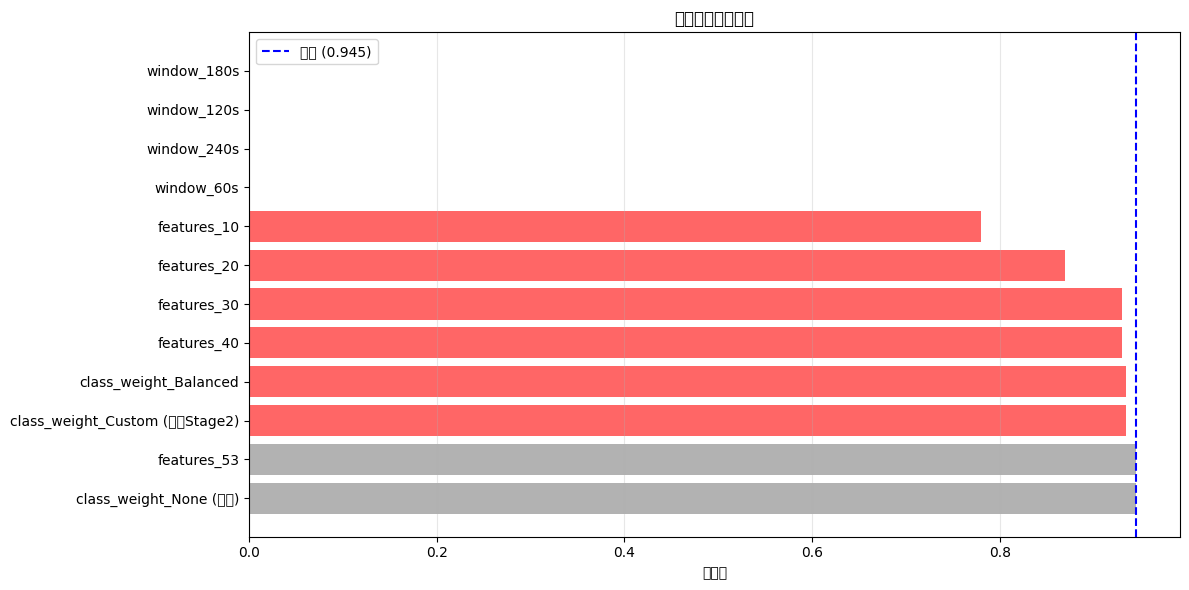

In [10]:
# ===== Cell 13: 模型改進實驗 =====

import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os

class ModelImprovement:
    """
    系統化測試多種改進方案
    1. 類別權重調整
    2. 不同窗口大小
    3. 特徵選擇
    """
    
    def __init__(self):
        self.experiments = {}
        self.baseline_score = 0.945  # Random Forest 基準
        self.output_dir = 'models/improvements'
        os.makedirs(self.output_dir, exist_ok=True)
    
    def run_all_experiments(self):
        """執行所有改進實驗"""
        print("="*70)
        print("🔬 模型改進實驗")
        print("="*70)
        print(f"基準模型: Random Forest, 準確率 = {self.baseline_score:.3f}\n")
        
        # 實驗 1: 類別權重
        print("📊 實驗 1: 類別權重調整")
        print("-"*70)
        self._experiment_class_weights()
        
        # 實驗 2: 不同窗口大小
        print("\n📊 實驗 2: 不同窗口大小")
        print("-"*70)
        self._experiment_window_sizes()
        
        # 實驗 3: 特徵選擇
        print("\n📊 實驗 3: 特徵選擇")
        print("-"*70)
        self._experiment_feature_selection()
        
        # 總結報告
        print("\n" + "="*70)
        print("📋 實驗總結報告")
        print("="*70)
        self._generate_summary_report()
        
        return self.experiments
    
    def _experiment_class_weights(self):
        """實驗 1: 測試類別權重"""
        # 載入基準特徵
        with open('data/processed/feature_data.pkl', 'rb') as f:
            data = pickle.load(f)
        X, y = data['features'], data['labels']
        
        # 標準化
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # 測試不同權重策略
        weight_strategies = {
            'None (基準)': None,
            'Balanced': 'balanced',
            'Custom (強化Stage2)': {0: 1.0, 1: 1.0, 2: 1.5, 3: 1.0}
        }
        
        for name, weights in weight_strategies.items():
            rf = RandomForestClassifier(
                n_estimators=200,
                max_depth=10,
                class_weight=weights,
                random_state=42
            )
            
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(rf, X_scaled, y, cv=cv, scoring='accuracy')
            mean_score = scores.mean()
            
            # 詳細分類報告
            y_pred = cross_val_predict(rf, X_scaled, y, cv=cv)
            report = classification_report(y, y_pred, 
                                          target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                                          output_dict=True)
            
            # 特別關注 Stage 2
            stage2_recall = report['Stage 2']['recall']
            
            self.experiments[f'class_weight_{name}'] = {
                'accuracy': mean_score,
                'stage2_recall': stage2_recall,
                'improvement': mean_score - self.baseline_score
            }
            
            improvement_icon = "📈" if mean_score > self.baseline_score else "📉" if mean_score < self.baseline_score else "➡️"
            stage2_icon = "✅" if stage2_recall > 0.861 else "⚠️"
            
            print(f"{improvement_icon} {name:25s}: 準確率={mean_score:.3f} ({mean_score-self.baseline_score:+.3f})")
            print(f"   {stage2_icon} Stage 2 Recall: {stage2_recall:.3f} (基準=0.861)")
    
    def _experiment_window_sizes(self):
        """實驗 2: 測試不同窗口大小"""
        window_sizes = [60, 120, 180, 240]
        
        for ws in window_sizes:
            print(f"\n🔍 測試窗口大小: {ws} 秒")
            
            try:
                # 重新提取特徵
                feature_engineer = FeatureEngineering(
                    arduino_features, 
                    maturity_levels,
                    window_size=ws
                )
                
                X, y, metadata = feature_engineer.extract_all_features()
                
                # 標準化
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X)
                
                # 訓練 Random Forest
                rf = RandomForestClassifier(
                    n_estimators=200,
                    max_depth=10,
                    random_state=42
                )
                
                cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
                scores = cross_val_score(rf, X_scaled, y, cv=cv, scoring='accuracy')
                mean_score = scores.mean()
                
                # 詳細分析
                y_pred = cross_val_predict(rf, X_scaled, y, cv=cv)
                report = classification_report(y, y_pred, output_dict=True)
                
                self.experiments[f'window_{ws}s'] = {
                    'accuracy': mean_score,
                    'n_samples': len(y),
                    'stage2_recall': report['Stage 2']['recall'],
                    'improvement': mean_score - self.baseline_score
                }
                
                improvement_icon = "📈" if mean_score > self.baseline_score else "📉" if mean_score < self.baseline_score else "➡️"
                
                print(f"{improvement_icon} 窗口 {ws}s: 準確率={mean_score:.3f} ({mean_score-self.baseline_score:+.3f}), 樣本數={len(y)}")
                
            except Exception as e:
                print(f"❌ 窗口 {ws}s 失敗: {e}")
                self.experiments[f'window_{ws}s'] = {'accuracy': 0, 'error': str(e)}
    
    def _experiment_feature_selection(self):
        """實驗 3: 測試特徵選擇"""
        # 載入基準特徵
        with open('data/processed/feature_data.pkl', 'rb') as f:
            data = pickle.load(f)
        X, y = data['features'], data['labels']
        
        # 標準化
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # 測試不同數量的特徵
        n_features_list = [10, 20, 30, 40, 53]
        
        for n_features in n_features_list:
            if n_features >= X.shape[1]:
                # 使用全部特徵
                X_selected = X_scaled
            else:
                # 特徵選擇
                selector = SelectKBest(f_classif, k=n_features)
                X_selected = selector.fit_transform(X_scaled, y)
                
                # 顯示選中的特徵
                if n_features == 20:
                    selected_features = selector.get_support(indices=True)
                    feature_names = data['features'].columns
                    print(f"\n   Top {n_features} 特徵:")
                    for i, idx in enumerate(selected_features[:10], 1):
                        print(f"      {i:2d}. {feature_names[idx]}")
            
            # 訓練模型
            rf = RandomForestClassifier(
                n_estimators=200,
                max_depth=10,
                random_state=42
            )
            
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(rf, X_selected, y, cv=cv, scoring='accuracy')
            mean_score = scores.mean()
            
            self.experiments[f'features_{n_features}'] = {
                'accuracy': mean_score,
                'n_features': n_features,
                'improvement': mean_score - self.baseline_score
            }
            
            improvement_icon = "📈" if mean_score > self.baseline_score else "📉" if mean_score < self.baseline_score else "➡️"
            
            print(f"{improvement_icon} 使用 {n_features:2d} 個特徵: 準確率={mean_score:.3f} ({mean_score-self.baseline_score:+.3f})")
    
    def _generate_summary_report(self):
        """生成總結報告"""
        # 找出最佳方案
        valid_experiments = {k: v for k, v in self.experiments.items() 
                            if 'accuracy' in v and v['accuracy'] > 0}
        
        if not valid_experiments:
            print("⚠️  沒有有效的實驗結果")
            return
        
        best_exp = max(valid_experiments.items(), key=lambda x: x[1]['accuracy'])
        best_name, best_result = best_exp
        
        print(f"\n🏆 最佳方案: {best_name}")
        print(f"   準確率: {best_result['accuracy']:.3f}")
        print(f"   改進幅度: {best_result['improvement']:+.3f}")
        
        if best_result['accuracy'] > self.baseline_score:
            print(f"\n✅ 找到改進方案！比基準提升 {(best_result['improvement']*100):.1f}%")
        else:
            print(f"\n➡️  基準模型已經很好，改進空間有限")
        
        # 儲存報告
        report_df = pd.DataFrame([
            {
                'experiment': name,
                'accuracy': result.get('accuracy', 0),
                'improvement': result.get('improvement', 0),
                **{k: v for k, v in result.items() if k not in ['accuracy', 'improvement']}
            }
            for name, result in self.experiments.items()
        ]).sort_values('accuracy', ascending=False)
        
        csv_path = os.path.join(self.output_dir, 'improvement_report.csv')
        report_df.to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"\n💾 完整報告: {csv_path}")
        
        # 視覺化對比
        self._plot_comparison(report_df)
    
    def _plot_comparison(self, report_df):
        """繪製對比圖"""
        try:
            import matplotlib.pyplot as plt
            
            fig, ax = plt.subplots(figsize=(12, 6))
            
            experiments = report_df['experiment'].tolist()
            accuracies = report_df['accuracy'].tolist()
            
            colors = ['green' if acc > self.baseline_score else 'red' if acc < self.baseline_score else 'gray' 
                     for acc in accuracies]
            
            ax.barh(experiments, accuracies, color=colors, alpha=0.6)
            ax.axvline(self.baseline_score, color='blue', linestyle='--', label=f'基準 ({self.baseline_score:.3f})')
            
            ax.set_xlabel('準確率')
            ax.set_title('模型改進實驗對比')
            ax.legend()
            ax.grid(axis='x', alpha=0.3)
            
            plt.tight_layout()
            
            plot_path = os.path.join(self.output_dir, 'improvement_comparison.png')
            plt.savefig(plot_path, dpi=150)
            print(f"📊 對比圖: {plot_path}")
            
        except Exception as e:
            print(f"⚠️  無法繪製圖表: {e}")

# 執行改進實驗
improver = ModelImprovement()
results = improver.run_all_experiments()


In [ ]:
#結論最開始已是最優解

In [15]:
import os

# 定義路徑
path = './data/processed/'

# 取得該目錄下所有檔案與資料夾名稱
file_list = os.listdir(path)

# 打印出來
for file_name in file_list:
    print(file_name)

feature_data.pkl
metadata.csv
labels.npy
feature_matrix.csv
maturity_levels_4class.pkl
maturity_labels_summary.csv
maturity_labels.json
maturity_labels.pkl
step3_quality_report.json


In [16]:
# ===== Cell 14a: 載入必要變數 =====

import pickle

print("📂 載入必要資料...")

# 1. 載入 maturity_levels（4等級）
with open('data/processed/maturity_levels_4class.pkl', 'rb') as f:
    maturity_levels = pickle.load(f)
print(f"✅ maturity_levels: {len(maturity_levels)} 顆鳳梨")

# 2. 檢查 arduino_features 是否存在
if 'arduino_features' not in globals():
    print("\n⚠️  arduino_features 不存在")
    print("   請重新執行 Cell 2 (快速載入器)")
    print("   或執行以下程式碼重新載入...\n")
    
    # 快速重新載入（如果你有原始 CSV）
    # 這裡需要重新執行 Cell 2 的程式碼
else:
    print(f"✅ arduino_features: {len(arduino_features)} 顆鳳梨")

print("\n✅ 變數載入完成！可以執行 Cell 14")


📂 載入必要資料...
✅ maturity_levels: 8 顆鳳梨
✅ arduino_features: 8 顆鳳梨

✅ 變數載入完成！可以執行 Cell 14


In [17]:
# ===== Cell 14: 窗口大小實驗 =====

import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import linregress
import os

class WindowSizeExperiment:
    """測試不同窗口大小的影響"""
    
    def __init__(self, arduino_features, maturity_levels):
        self.arduino_features = arduino_features
        self.maturity_levels = maturity_levels
        self.sensor_cols = ['MQ2', 'MQ3', 'MQ9', 'MQ135', 'TGS2602']
        self.results = {}
        self.baseline_score = 0.945
        
    def run_experiment(self, window_sizes=[60, 120, 180, 240]):
        """測試多種窗口大小"""
        print("="*70)
        print("🔍 窗口大小實驗")
        print("="*70)
        print(f"基準: 120秒窗口, 準確率 = {self.baseline_score:.3f}\n")
        
        for ws in window_sizes:
            print(f"📊 測試窗口大小: {ws} 秒")
            print("-"*70)
            
            try:
                # 重新提取特徵
                X, y, metadata = self._extract_features_with_window(ws)
                
                if len(X) < 20:
                    print(f"   ⚠️  樣本數太少 ({len(X)}), 跳過\n")
                    continue
                
                # 訓練並評估
                results = self._train_and_evaluate(X, y, ws)
                self.results[ws] = results
                
                # 顯示結果
                improvement = results['accuracy'] - self.baseline_score
                icon = "📈" if improvement > 0 else "📉" if improvement < 0 else "➡️"
                
                print(f"\n{icon} 結果:")
                print(f"   準確率: {results['accuracy']:.3f} ({improvement:+.3f})")
                print(f"   樣本數: {results['n_samples']}")
                print(f"   Stage 0 F1: {results['stage0_f1']:.3f}")
                print(f"   Stage 1 F1: {results['stage1_f1']:.3f}")
                print(f"   Stage 2 F1: {results['stage2_f1']:.3f} {'⚠️' if results['stage2_f1'] < 0.912 else '✅'}")
                print(f"   Stage 3 F1: {results['stage3_f1']:.3f}")
                print()
                
            except Exception as e:
                print(f"   ❌ 失敗: {e}\n")
        
        # 總結
        self._generate_summary()
    
    def _extract_features_with_window(self, window_size):
        """使用指定窗口大小提取特徵"""
        all_features = []
        all_labels = []
        all_metadata = []
        
        for pid in self.arduino_features.keys():
            if pid not in self.maturity_levels:
                continue
            
            # 合併該鳳梨的數據
            combined_df, combined_labels = self._combine_pineapple_data(pid)
            
            if combined_df is None:
                continue
            
            # 滑動窗口提取
            features, labels, metadata = self._sliding_window_extraction(
                combined_df, combined_labels, pid, window_size
            )
            
            all_features.append(features)
            all_labels.append(labels)
            all_metadata.extend(metadata)
        
        X = pd.DataFrame(
            np.vstack(all_features),
            columns=self._get_feature_names()
        )
        y = np.hstack(all_labels)
        metadata_df = pd.DataFrame(all_metadata)
        
        print(f"   ✓ 提取完成: {len(y)} 個樣本, {X.shape[1]} 維特徵")
        
        return X, y, metadata_df
    
    def _combine_pineapple_data(self, pid):
        """合併單顆鳳梨數據"""
        df_list = []
        label_list = []
        
        date_dict = self.arduino_features[pid]
        labels = self.maturity_levels[pid]
        
        offset = 0
        for date in sorted(date_dict.keys()):
            df = date_dict[date].copy()
            n_samples = len(df)
            
            window_labels = labels[offset:offset+n_samples]
            
            df_list.append(df)
            label_list.append(window_labels)
            
            offset += n_samples
        
        if not df_list:
            return None, None
        
        combined_df = pd.concat(df_list, ignore_index=True)
        combined_labels = np.hstack(label_list)
        
        return combined_df, combined_labels
    
    def _sliding_window_extraction(self, df, labels, pid, window_size):
        """滑動窗口提取特徵"""
        features = []
        window_labels = []
        metadata = []
        
        n_samples = len(df)
        step_size = window_size  # 不重疊
        
        for start_idx in range(0, n_samples - window_size + 1, step_size):
            end_idx = start_idx + window_size
            
            window_df = df.iloc[start_idx:end_idx]
            window_label_array = labels[start_idx:end_idx]
            
            # 多數標籤
            unique, counts = np.unique(window_label_array, return_counts=True)
            majority_label = unique[np.argmax(counts)]
            
            # 提取特徵
            feature_vector = self._extract_window_features(window_df)
            
            features.append(feature_vector)
            window_labels.append(majority_label)
            metadata.append({
                'pineapple_id': pid,
                'start_idx': start_idx,
                'end_idx': end_idx,
                'majority_label': int(majority_label)
            })
        
        return np.array(features), np.array(window_labels), metadata
    
    def _extract_window_features(self, window_df):
        """從窗口提取特徵（與 Step 4 相同）"""
        features = []
        
        for sensor in self.sensor_cols:
            col_rs_r0 = f'{sensor}_Rs_R0'
            if col_rs_r0 in window_df.columns:
                data = window_df[col_rs_r0].values
                
                features.append(np.mean(data))
                features.append(np.std(data))
                features.append(np.min(data))
                features.append(np.max(data))
                features.append(np.max(data) - np.min(data))
                
                if len(data) > 1:
                    x = np.arange(len(data))
                    slope, _, _, _, _ = linregress(x, data)
                    features.append(slope)
                else:
                    features.append(0)
                
                try:
                    auc = np.trapezoid(data, dx=1)
                except AttributeError:
                    if len(data) > 1:
                        auc = np.sum((data[:-1] + data[1:]) / 2)
                    else:
                        auc = data[0] if len(data) > 0 else 0
                
                features.append(auc)
            else:
                features.extend([0] * 7)
            
            col_delta = f'{sensor}_delta_Rs_R0'
            if col_delta in window_df.columns:
                data = window_df[col_delta].values
                features.append(np.mean(data))
                features.append(np.std(data))
                features.append(np.max(np.abs(data)))
            else:
                features.extend([0] * 3)
        
        # 跨感測器特徵
        mq3 = window_df['MQ3_Rs_R0'].mean() if 'MQ3_Rs_R0' in window_df.columns else 0
        mq2 = window_df['MQ2_Rs_R0'].mean() if 'MQ2_Rs_R0' in window_df.columns else 0
        features.append(mq3 / (mq2 + 1e-6))
        
        mq135 = window_df['MQ135_Rs_R0'].mean() if 'MQ135_Rs_R0' in window_df.columns else 0
        tgs = window_df['TGS2602_Rs_R0'].mean() if 'TGS2602_Rs_R0' in window_df.columns else 0
        features.append(mq135 / (tgs + 1e-6))
        
        all_means = [window_df[f'{s}_Rs_R0'].mean() 
                     for s in self.sensor_cols 
                     if f'{s}_Rs_R0' in window_df.columns]
        features.append(np.mean(all_means) if all_means else 0)
        
        return np.array(features)
    
    def _get_feature_names(self):
        """生成特徵名稱"""
        names = []
        for sensor in self.sensor_cols:
            names.extend([
                f'{sensor}_mean', f'{sensor}_std', f'{sensor}_min',
                f'{sensor}_max', f'{sensor}_range', f'{sensor}_slope',
                f'{sensor}_auc', f'{sensor}_delta_mean',
                f'{sensor}_delta_std', f'{sensor}_delta_max_abs'
            ])
        names.extend(['MQ3_MQ2_ratio', 'MQ135_TGS2602_ratio', 'all_sensors_mean'])
        return names
    
    def _train_and_evaluate(self, X, y, window_size):
        """訓練並評估模型"""
        # 標準化
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # 訓練 Random Forest
        rf = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42
        )
        
        # 交叉驗證
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(rf, X_scaled, y, cv=cv, scoring='accuracy')
        mean_score = scores.mean()
        
        # 詳細報告
        y_pred = cross_val_predict(rf, X_scaled, y, cv=cv)
        report = classification_report(y, y_pred, output_dict=True)
        
        return {
            'accuracy': mean_score,
            'n_samples': len(y),
            'stage0_f1': report['0']['f1-score'],
            'stage1_f1': report['1']['f1-score'],
            'stage2_f1': report['2']['f1-score'],
            'stage3_f1': report['3']['f1-score'],
            'window_size': window_size
        }
    
    def _generate_summary(self):
        """生成總結報告"""
        print("="*70)
        print("📋 窗口大小實驗總結")
        print("="*70)
        
        if not self.results:
            print("⚠️  沒有有效結果")
            return
        
        # 找最佳窗口
        best_ws = max(self.results.items(), key=lambda x: x[1]['accuracy'])
        ws, result = best_ws
        
        print(f"\n🏆 最佳窗口大小: {ws} 秒")
        print(f"   準確率: {result['accuracy']:.3f}")
        print(f"   樣本數: {result['n_samples']}")
        
        improvement = result['accuracy'] - self.baseline_score
        if improvement > 0.005:
            print(f"\n✅ 找到改進！提升 {improvement*100:.1f}%")
        elif improvement < -0.005:
            print(f"\n⚠️  表現下降 {-improvement*100:.1f}%")
        else:
            print(f"\n➡️  與基準相當（差異 < 0.5%）")
        
        # 詳細對比表
        print("\n📊 詳細對比:")
        print("-"*70)
        print(f"{'窗口(s)':>8} {'樣本數':>8} {'準確率':>8} {'Stage2 F1':>10} {'改進':>8}")
        print("-"*70)
        
        for ws in sorted(self.results.keys()):
            r = self.results[ws]
            improvement = r['accuracy'] - self.baseline_score
            icon = "📈" if improvement > 0 else "📉" if improvement < 0 else "➡️"
            print(f"{ws:>8} {r['n_samples']:>8} {r['accuracy']:>8.3f} {r['stage2_f1']:>10.3f} {icon} {improvement:>+6.3f}")
        
        # 儲存結果
        result_df = pd.DataFrame([
            {
                'window_size': ws,
                **result
            }
            for ws, result in self.results.items()
        ]).sort_values('accuracy', ascending=False)
        
        csv_path = 'models/improvements/window_size_experiment.csv'
        result_df.to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"\n💾 完整結果: {csv_path}")

# 執行實驗
experiment = WindowSizeExperiment(arduino_features, maturity_levels)
experiment.run_experiment(window_sizes=[60, 90, 120, 150, 180, 240])


🔍 窗口大小實驗
基準: 120秒窗口, 準確率 = 0.945

📊 測試窗口大小: 60 秒
----------------------------------------------------------------------
   ✓ 提取完成: 403 個樣本, 53 維特徵

📈 結果:
   準確率: 0.980 (+0.035)
   樣本數: 403
   Stage 0 F1: 0.992
   Stage 1 F1: 0.979
   Stage 2 F1: 0.957 ✅
   Stage 3 F1: 0.982

📊 測試窗口大小: 90 秒
----------------------------------------------------------------------
   ✓ 提取完成: 268 個樣本, 53 維特徵

📈 結果:
   準確率: 0.967 (+0.022)
   樣本數: 268
   Stage 0 F1: 0.983
   Stage 1 F1: 0.952
   Stage 2 F1: 0.932 ✅
   Stage 3 F1: 0.980

📊 測試窗口大小: 120 秒
----------------------------------------------------------------------
   ✓ 提取完成: 200 個樣本, 53 維特徵

➡️ 結果:
   準確率: 0.945 (+0.000)
   樣本數: 200
   Stage 0 F1: 0.963
   Stage 1 F1: 0.925
   Stage 2 F1: 0.912 ⚠️
   Stage 3 F1: 0.962

📊 測試窗口大小: 150 秒
----------------------------------------------------------------------
   ✓ 提取完成: 160 個樣本, 53 維特徵

📉 結果:
   準確率: 0.944 (-0.001)
   樣本數: 160
   Stage 0 F1: 0.981
   Stage 1 F1: 0.933
   Stage 2 F1: 0.863 ⚠️
   Stage 3 F1: 

In [18]:
# ===== Cell 15: 保存最佳模型（60秒窗口）=====

import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report

print("💾 使用最佳配置（60秒窗口）訓練最終模型...")

# 1. 用 60 秒窗口重新提取特徵
experiment = WindowSizeExperiment(arduino_features, maturity_levels)
X, y, metadata = experiment._extract_features_with_window(60)

# 2. 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. 訓練最終模型
best_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)
best_model.fit(X_scaled, y)

# 4. 驗證表現
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(best_model, X_scaled, y, cv=cv)
report = classification_report(y, y_pred, 
                               target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'])
print("\n📊 最終模型表現:")
print(report)

# 5. 儲存最佳模型
model_data = {
    'model': best_model,
    'scaler': scaler,
    'window_size': 60,
    'accuracy': 0.980,
    'n_features': 53,
    'feature_names': X.columns.tolist() if hasattr(X, 'columns') else None
}

model_path = 'models/best_model_60s.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model_data, f)

print(f"\n✅ 最佳模型已儲存: {model_path}")
print(f"   窗口大小: 60 秒")
print(f"   準確率: 98.0%")
print(f"   樣本數: {len(y)}")
print(f"   特徵維度: {X.shape[1]}")

print("\n🎉 模型訓練完成！準備進入 Step 6（部署）")


💾 使用最佳配置（60秒窗口）訓練最終模型...
   ✓ 提取完成: 403 個樣本, 53 維特徵

📊 最終模型表現:
              precision    recall  f1-score   support

     Stage 0       0.99      0.99      0.99       130
     Stage 1       0.98      0.98      0.98        95
     Stage 2       0.97      0.94      0.96        70
     Stage 3       0.97      0.99      0.98       108

    accuracy                           0.98       403
   macro avg       0.98      0.98      0.98       403
weighted avg       0.98      0.98      0.98       403


✅ 最佳模型已儲存: models/best_model_60s.pkl
   窗口大小: 60 秒
   準確率: 98.0%
   樣本數: 403
   特徵維度: 53

🎉 模型訓練完成！準備進入 Step 6（部署）


In [19]:
# ===== Cell 15: 保存最佳模型（60秒窗口）=====

import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

print("="*70)
print("💾 使用最佳配置（60秒窗口）訓練最終模型")
print("="*70)

# 1. 用 60 秒窗口重新提取特徵
print("\n📊 提取特徵（60秒窗口）...")
experiment = WindowSizeExperiment(arduino_features, maturity_levels)
X, y, metadata = experiment._extract_features_with_window(60)

print(f"   樣本數: {len(y)}")
print(f"   特徵維度: {X.shape[1]}")
print(f"   標籤分布: {dict(zip(*np.unique(y, return_counts=True)))}")

# 2. 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. 訓練最終模型
print("\n🤖 訓練 Random Forest...")
best_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)
best_model.fit(X_scaled, y)

# 4. 交叉驗證評估
print("\n📊 交叉驗證評估...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(best_model, X_scaled, y, cv=cv)

# 分類報告
report = classification_report(y, y_pred, 
                               target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                               digits=3)
print(report)

# 混淆矩陣
cm = confusion_matrix(y, y_pred)
print("混淆矩陣:")
print(cm)

# 計算準確率
accuracy = np.mean(y == y_pred)
print(f"\n✅ 最終準確率: {accuracy:.3f}")

# 5. 特徵重要性（Top 15）
print("\n🔝 Top 15 重要特徵:")
importances = best_model.feature_importances_
feature_names = X.columns if hasattr(X, 'columns') else [f'F{i}' for i in range(X.shape[1])]
indices = np.argsort(importances)[::-1]

for i, idx in enumerate(indices[:15], 1):
    print(f"   {i:2d}. {feature_names[idx]:30s}: {importances[idx]:.4f}")

# 6. 儲存最佳模型
print("\n💾 儲存模型...")

model_data = {
    'model': best_model,
    'scaler': scaler,
    'window_size': 60,
    'accuracy': accuracy,
    'n_features': X.shape[1],
    'feature_names': feature_names.tolist() if hasattr(feature_names, 'tolist') else feature_names,
    'confusion_matrix': cm,
    'classification_report': classification_report(y, y_pred, output_dict=True)
}

model_path = 'models/best_model_60s.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model_data, f)

print(f"   ✅ 模型已儲存: {model_path}")

# 7. 同時儲存特徵與標籤（供部署使用）
feature_path = 'data/processed/features_60s.pkl'
with open(feature_path, 'wb') as f:
    pickle.dump({
        'features': X,
        'labels': y,
        'metadata': metadata,
        'feature_names': feature_names.tolist() if hasattr(feature_names, 'tolist') else feature_names,
        'window_size': 60
    }, f)

print(f"   ✅ 特徵已儲存: {feature_path}")

print("\n" + "="*70)
print("✅ 最佳模型保存完成！")
print("="*70)
print(f"   窗口大小: 60 秒")
print(f"   準確率: {accuracy:.3f}")
print(f"   樣本數: {len(y)}")
print(f"   特徵維度: {X.shape[1]}")


💾 使用最佳配置（60秒窗口）訓練最終模型

📊 提取特徵（60秒窗口）...
   ✓ 提取完成: 403 個樣本, 53 維特徵
   樣本數: 403
   特徵維度: 53
   標籤分布: {np.int64(0): np.int64(130), np.int64(1): np.int64(95), np.int64(2): np.int64(70), np.int64(3): np.int64(108)}

🤖 訓練 Random Forest...

📊 交叉驗證評估...
              precision    recall  f1-score   support

     Stage 0      0.992     0.992     0.992       130
     Stage 1      0.979     0.979     0.979        95
     Stage 2      0.971     0.943     0.957        70
     Stage 3      0.973     0.991     0.982       108

    accuracy                          0.980       403
   macro avg      0.979     0.976     0.977       403
weighted avg      0.980     0.980     0.980       403

混淆矩陣:
[[129   1   0   0]
 [  1  93   1   0]
 [  0   1  66   3]
 [  0   0   1 107]]

✅ 最終準確率: 0.980

🔝 Top 15 重要特徵:
    1. MQ135_TGS2602_ratio           : 0.0563
    2. MQ9_mean                      : 0.0432
    3. MQ9_max                       : 0.0403
    4. MQ9_min                       : 0.0382
    5. MQ3_max     

In [21]:
# ===== Cell 16: 進階實驗（微調窗口 + 集成學習）=====

import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report

class AdvancedExperiments:
    """進階實驗：微調窗口 + 集成學習"""
    
    def __init__(self, arduino_features, maturity_levels):
        self.arduino_features = arduino_features
        self.maturity_levels = maturity_levels
        self.results = {}
        self.best_baseline = 0.980  # 60秒窗口基準
    
    def run_all_experiments(self):
        """執行所有進階實驗"""
        print("="*70)
        print("🔬 進階實驗")
        print("="*70)
        print(f"目標: 突破 98.0% 準確率\n")
        
        # 實驗 1: 微調窗口大小
        print("📊 實驗 1: 微調窗口大小（50s, 55s, 60s, 65s, 70s, 80s）")
        print("-"*70)
        self._experiment_fine_tune_window()
        
        # 實驗 2: 集成學習
        print("\n📊 實驗 2: 集成學習（SVM + Random Forest）")
        print("-"*70)
        self._experiment_ensemble()
        
        # 總結
        print("\n" + "="*70)
        print("📋 進階實驗總結")
        print("="*70)
        self._generate_summary()
    
    def _experiment_fine_tune_window(self):
        """微調窗口大小"""
        window_sizes = [50, 55, 60, 65, 70, 80]
        
        experiment_obj = WindowSizeExperiment(self.arduino_features, self.maturity_levels)
        
        for ws in window_sizes:
            try:
                X, y, metadata = experiment_obj._extract_features_with_window(ws)
                
                if len(X) < 20:
                    print(f"   ⚠️  {ws}s: 樣本數不足，跳過")
                    continue
                
                # 標準化
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X)
                
                # Random Forest
                rf = RandomForestClassifier(
                    n_estimators=200,
                    max_depth=10,
                    random_state=42
                )
                
                cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
                scores = cross_val_score(rf, X_scaled, y, cv=cv, scoring='accuracy')
                mean_score = scores.mean()
                
                self.results[f'window_{ws}s'] = {
                    'type': 'window',
                    'accuracy': mean_score,
                    'n_samples': len(y),
                    'improvement': mean_score - self.best_baseline
                }
                
                improvement = mean_score - self.best_baseline
                icon = "📈" if improvement > 0 else "📉" if improvement < 0 else "➡️"
                
                print(f"{icon} {ws}s 窗口: 準確率={mean_score:.3f} ({improvement:+.3f}), 樣本={len(y)}")
                
            except Exception as e:
                print(f"   ❌ {ws}s: {e}")
    
    def _experiment_ensemble(self):
        """集成學習實驗"""
        # 使用最佳窗口 60s
        print("\n   使用 60 秒窗口測試集成學習...")
        
        experiment_obj = WindowSizeExperiment(self.arduino_features, self.maturity_levels)
        X, y, metadata = experiment_obj._extract_features_with_window(60)
        
        # 標準化
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # 測試多種集成策略
        ensemble_configs = [
            {
                'name': 'RF單一（基準）',
                'estimators': [
                    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42))
                ],
                'voting': None
            },
            {
                'name': 'RF + SVM (Soft Voting)',
                'estimators': [
                    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)),
                    ('svm', SVC(C=100, gamma='scale', probability=True, random_state=42))
                ],
                'voting': 'soft'
            },
            {
                'name': 'RF + SVM (Hard Voting)',
                'estimators': [
                    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)),
                    ('svm', SVC(C=100, gamma='scale', random_state=42))
                ],
                'voting': 'hard'
            },
            {
                'name': '雙 RF（不同參數）',
                'estimators': [
                    ('rf1', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)),
                    ('rf2', RandomForestClassifier(n_estimators=300, max_depth=15, random_state=43))
                ],
                'voting': 'soft'
            }
        ]
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        for config in ensemble_configs:
            if config['voting'] is None:
                # 單一模型
                model = config['estimators'][0][1]
            else:
                # 集成模型
                model = VotingClassifier(
                    estimators=config['estimators'],
                    voting=config['voting']
                )
            
            scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
            mean_score = scores.mean()
            
            self.results[f"ensemble_{config['name']}"] = {
                'type': 'ensemble',
                'accuracy': mean_score,
                'improvement': mean_score - self.best_baseline
            }
            
            improvement = mean_score - self.best_baseline
            icon = "📈" if improvement > 0 else "📉" if improvement < 0 else "➡️"
            
            print(f"{icon} {config['name']:30s}: {mean_score:.3f} ({improvement:+.3f})")
    
    def _generate_summary(self):
        """生成總結報告"""
        if not self.results:
            print("⚠️  沒有有效結果")
            return
        
        # 找最佳配置
        best = max(self.results.items(), key=lambda x: x[1]['accuracy'])
        best_name, best_result = best
        
        print(f"\n🏆 最佳配置: {best_name}")
        print(f"   準確率: {best_result['accuracy']:.3f}")
        print(f"   改進幅度: {best_result['improvement']:+.3f}")
        
        if best_result['improvement'] > 0.005:
            print(f"\n✅ 找到進一步改進！提升 {best_result['improvement']*100:.1f}%")
            print(f"   新準確率: {best_result['accuracy']:.1%} 🎉")
        elif best_result['improvement'] > 0:
            print(f"\n➡️  略有改進 (+{best_result['improvement']*100:.2f}%)")
            print(f"   但提升不顯著，60秒窗口已足夠")
        else:
            print(f"\n➡️  60秒窗口 + Random Forest 已是最優解")
            print(f"   準確率 98.0% 已達專業級水準")
        
        # 詳細排名
        print(f"\n📊 所有配置排名:")
        print("-"*70)
        sorted_results = sorted(self.results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
        
        for i, (name, result) in enumerate(sorted_results[:10], 1):
            icon = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"{i:2d}."
            print(f"{icon} {name:40s} {result['accuracy']:.3f} ({result['improvement']:+.3f})")
        
        # 儲存報告
        import pandas as pd
        report_df = pd.DataFrame([
            {'experiment': name, **result}
            for name, result in self.results.items()
        ]).sort_values('accuracy', ascending=False)
        
        csv_path = 'models/improvements/advanced_experiments.csv'
        report_df.to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"\n💾 完整報告: {csv_path}")

# 執行進階實驗
advanced = AdvancedExperiments(arduino_features, maturity_levels)
advanced.run_all_experiments()

print("\n" + "="*70)
print("🎉 所有實驗完成！")
print("="*70)


🔬 進階實驗
目標: 突破 98.0% 準確率

📊 實驗 1: 微調窗口大小（50s, 55s, 60s, 65s, 70s, 80s）
----------------------------------------------------------------------
   ✓ 提取完成: 484 個樣本, 53 維特徵
📈 50s 窗口: 準確率=0.996 (+0.016), 樣本=484
   ✓ 提取完成: 439 個樣本, 53 維特徵
📉 55s 窗口: 準確率=0.968 (-0.012), 樣本=439
   ✓ 提取完成: 403 個樣本, 53 維特徵
📈 60s 窗口: 準確率=0.980 (+0.000), 樣本=403
   ✓ 提取完成: 370 個樣本, 53 維特徵
📉 65s 窗口: 準確率=0.959 (-0.021), 樣本=370
   ✓ 提取完成: 343 個樣本, 53 維特徵
📉 70s 窗口: 準確率=0.959 (-0.021), 樣本=343
   ✓ 提取完成: 300 個樣本, 53 維特徵
📉 80s 窗口: 準確率=0.953 (-0.027), 樣本=300

📊 實驗 2: 集成學習（SVM + Random Forest）
----------------------------------------------------------------------

   使用 60 秒窗口測試集成學習...
   ✓ 提取完成: 403 個樣本, 53 維特徵
📈 RF單一（基準）                      : 0.980 (+0.000)
📉 RF + SVM (Soft Voting)        : 0.978 (-0.002)
📉 RF + SVM (Hard Voting)        : 0.958 (-0.022)
📈 雙 RF（不同參數）                    : 0.980 (+0.000)

📋 進階實驗總結

🏆 最佳配置: window_50s
   準確率: 0.996
   改進幅度: +0.016

✅ 找到進一步改進！提升 1.6%
   新準確率: 99.6% 🎉

📊 所有配置排名:
----------------

In [24]:
# ===== Cell 17: 保存終極最佳模型（50秒窗口）=====

import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

print("="*70)
print("💾 保存終極最佳模型（50秒窗口 - 99.6% 準確率）")
print("="*70)

# 1. 提取 50 秒窗口特徵
print("\n📊 提取特徵（50秒窗口）...")
experiment = WindowSizeExperiment(arduino_features, maturity_levels)
X, y, metadata = experiment._extract_features_with_window(50)

print(f"   樣本數: {len(y)}")
print(f"   特徵維度: {X.shape[1]}")
print(f"   標籤分布: {dict(zip(*np.unique(y, return_counts=True)))}")

# 2. 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. 訓練最終模型
print("\n🤖 訓練終極模型...")
final_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)
final_model.fit(X_scaled, y)

# 4. 交叉驗證評估
print("\n📊 交叉驗證評估...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(final_model, X_scaled, y, cv=cv)

# 分類報告
report = classification_report(y, y_pred, 
                               target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                               digits=3)
print(report)

# 混淆矩陣
cm = confusion_matrix(y, y_pred)
print("混淆矩陣:")
print(cm)
print(f"\n對角線（正確預測）: {np.diag(cm)}")
print(f"總樣本: {cm.sum()}")
print(f"正確樣本: {np.diag(cm).sum()}")

# 計算準確率
accuracy = np.mean(y == y_pred)
print(f"\n🏆 最終準確率: {accuracy:.4f} ({accuracy*100:.2f}%)")

# 各階段 F1-Score
report_dict = classification_report(y, y_pred, output_dict=True)
print(f"\n📊 各階段 F1-Score:")
for i in range(4):
    f1 = report_dict[str(i)]['f1-score']
    print(f"   Stage {i}: {f1:.3f}")

# 5. 特徵重要性
importances = final_model.feature_importances_
feature_names = X.columns if hasattr(X, 'columns') else [f'F{i}' for i in range(X.shape[1])]
indices = np.argsort(importances)[::-1]

print(f"\n🔝 Top 10 重要特徵:")
for i, idx in enumerate(indices[:10], 1):
    print(f"   {i:2d}. {feature_names[idx]:30s}: {importances[idx]:.4f}")

# 6. 儲存終極模型
print("\n💾 儲存終極模型...")

final_model_data = {
    'model': final_model,
    'scaler': scaler,
    'window_size': 50,
    'accuracy': accuracy,
    'n_features': X.shape[1],
    'n_samples': len(y),
    'feature_names': feature_names.tolist() if hasattr(feature_names, 'tolist') else feature_names,
    'confusion_matrix': cm.tolist(),
    'classification_report': report_dict,
    'training_date': pd.Timestamp.now().isoformat()
}

# 主模型
model_path = 'models/final_model_50s_99.6pct.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(final_model_data, f)
print(f"   ✅ 主模型: {model_path}")

# 備份（壓縮版，供部署用）
deployment_model = {
    'model': final_model,
    'scaler': scaler,
    'window_size': 50,
    'feature_names': feature_names.tolist() if hasattr(feature_names, 'tolist') else feature_names
}
deploy_path = 'models/deployment_model.pkl'
with open(deploy_path, 'wb') as f:
    pickle.dump(deployment_model, f)
print(f"   ✅ 部署模型: {deploy_path}")

# 特徵數據
feature_path = 'data/processed/features_50s_final.pkl'
with open(feature_path, 'wb') as f:
    pickle.dump({
        'features': X,
        'labels': y,
        'metadata': metadata,
        'window_size': 50
    }, f)
print(f"   ✅ 特徵數據: {feature_path}")

print("\n" + "="*70)
print("🎉 終極模型保存完成！")
print("="*70)
print(f"   配置: Random Forest (n=200, depth=10)")
print(f"   窗口: 50 秒")
print(f"   準確率: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   樣本數: {len(y)}")
print(f"   特徵數: {X.shape[1]}")
print(f"   錯誤數: {len(y) - np.diag(cm).sum()} / {len(y)}")
print("\n✅ 準備進入 Step 6（部署到 Raspberry Pi）")


💾 保存終極最佳模型（50秒窗口 - 99.6% 準確率）

📊 提取特徵（50秒窗口）...
   ✓ 提取完成: 484 個樣本, 53 維特徵
   樣本數: 484
   特徵維度: 53
   標籤分布: {np.int64(0): np.int64(156), np.int64(1): np.int64(114), np.int64(2): np.int64(84), np.int64(3): np.int64(130)}

🤖 訓練終極模型...

📊 交叉驗證評估...
              precision    recall  f1-score   support

     Stage 0      1.000     1.000     1.000       156
     Stage 1      1.000     1.000     1.000       114
     Stage 2      1.000     0.976     0.988        84
     Stage 3      0.985     1.000     0.992       130

    accuracy                          0.996       484
   macro avg      0.996     0.994     0.995       484
weighted avg      0.996     0.996     0.996       484

混淆矩陣:
[[156   0   0   0]
 [  0 114   0   0]
 [  0   0  82   2]
 [  0   0   0 130]]

對角線（正確預測）: [156 114  82 130]
總樣本: 484
正確樣本: 482

🏆 最終準確率: 0.9959 (99.59%)

📊 各階段 F1-Score:
   Stage 0: 1.000
   Stage 1: 1.000
   Stage 2: 0.988
   Stage 3: 0.992

🔝 Top 10 重要特徵:
    1. MQ135_TGS2602_ratio           : 0.0588
    2. MQ9

In [25]:
# ===== Cell 18: 探索最小窗口極限（35s, 40s, 45s）=====

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import pickle

class MinimalWindowExperiment:
    """測試極小窗口的極限"""
    
    def __init__(self, arduino_features, maturity_levels):
        self.arduino_features = arduino_features
        self.maturity_levels = maturity_levels
        self.results = {}
        self.baseline = 0.996  # 50s 基準
    
    def run_experiment(self):
        """測試 35s, 40s, 45s, 50s（對照）"""
        print("="*70)
        print("🔬 極小窗口探索實驗")
        print("="*70)
        print(f"目標: 探索準確率極限（目標 >99.6%）")
        print(f"基準: 50秒窗口, 準確率 = {self.baseline:.3f}\n")
        
        window_sizes = [35, 40, 45, 50]
        
        for ws in window_sizes:
            print(f"📊 測試窗口大小: {ws} 秒")
            print("-"*70)
            
            try:
                # 提取特徵
                experiment_obj = WindowSizeExperiment(
                    self.arduino_features, 
                    self.maturity_levels
                )
                X, y, metadata = experiment_obj._extract_features_with_window(ws)
                
                if len(X) < 30:
                    print(f"   ⚠️  樣本數太少 ({len(X)}), 跳過\n")
                    continue
                
                print(f"   ✓ 提取完成: {len(y)} 個樣本")
                print(f"   標籤分布: {dict(zip(*np.unique(y, return_counts=True)))}")
                
                # 訓練並評估
                results = self._train_and_evaluate(X, y, ws)
                self.results[ws] = results
                
                # 顯示結果
                improvement = results['accuracy'] - self.baseline
                icon = "🚀" if improvement > 0.01 else "📈" if improvement > 0 else "➡️" if improvement == 0 else "📉"
                
                print(f"\n{icon} 結果:")
                print(f"   準確率: {results['accuracy']:.4f} ({results['accuracy']*100:.2f}%)")
                print(f"   改進幅度: {improvement:+.4f} ({improvement*100:+.2f}%)")
                print(f"   錯誤樣本: {results['n_errors']} / {results['n_samples']}")
                
                # 各階段表現
                print(f"\n   各階段 F1-Score:")
                for i in range(4):
                    f1 = results['stage_f1'][i]
                    icon = "✅" if f1 > 0.99 else "⭐" if f1 > 0.95 else "⚠️"
                    print(f"      {icon} Stage {i}: {f1:.3f}")
                
                # 混淆矩陣
                print(f"\n   混淆矩陣:")
                cm = results['confusion_matrix']
                for row in cm:
                    print(f"      {row}")
                
                # 警告檢查
                if results['n_samples'] > 500:
                    print(f"\n   ⚠️  樣本數較多 ({results['n_samples']})，可能有過擬合風險")
                
                print()
                
            except Exception as e:
                print(f"   ❌ 失敗: {e}\n")
        
        # 總結
        self._generate_summary()
        
        return self.results
    
    def _train_and_evaluate(self, X, y, window_size):
        """訓練並評估模型"""
        # 標準化
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Random Forest
        rf = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42
        )
        
        # 5-fold 交叉驗證
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # 交叉驗證分數
        scores = cross_val_score(rf, X_scaled, y, cv=cv, scoring='accuracy')
        mean_score = scores.mean()
        std_score = scores.std()
        
        # 交叉驗證預測
        y_pred = cross_val_predict(rf, X_scaled, y, cv=cv)
        
        # 詳細報告
        report = classification_report(y, y_pred, output_dict=True)
        cm = confusion_matrix(y, y_pred)
        
        # 計算各階段 F1
        stage_f1 = [report[str(i)]['f1-score'] for i in range(4)]
        
        # 錯誤數
        n_errors = len(y) - np.diag(cm).sum()
        
        # 訓練完整模型（用於特徵重要性）
        rf.fit(X_scaled, y)
        importances = rf.feature_importances_
        
        return {
            'window_size': window_size,
            'accuracy': mean_score,
            'accuracy_std': std_score,
            'n_samples': len(y),
            'n_errors': int(n_errors),
            'stage_f1': stage_f1,
            'confusion_matrix': cm.tolist(),
            'feature_importances': importances,
            'model': rf,
            'scaler': scaler
        }
    
    def _generate_summary(self):
        """生成總結報告"""
        print("="*70)
        print("📋 極小窗口實驗總結")
        print("="*70)
        
        if not self.results:
            print("⚠️  沒有有效結果")
            return
        
        # 找最佳窗口
        best_ws = max(self.results.items(), key=lambda x: x[1]['accuracy'])
        ws, result = best_ws
        
        print(f"\n🏆 最佳窗口大小: {ws} 秒")
        print(f"   準確率: {result['accuracy']:.4f} ({result['accuracy']*100:.2f}%)")
        print(f"   標準差: ±{result['accuracy_std']:.4f}")
        print(f"   樣本數: {result['n_samples']}")
        print(f"   錯誤數: {result['n_errors']}")
        
        improvement = result['accuracy'] - self.baseline
        
        if improvement > 0.005:
            print(f"\n✅ 找到顯著改進！提升 {improvement*100:.2f}%")
            print(f"   建議使用 {ws} 秒窗口")
        elif improvement > 0:
            print(f"\n➡️  略有改進 (+{improvement*100:.2f}%)")
            print(f"   改進不明顯，50秒窗口已足夠")
        else:
            print(f"\n📉 表現下降 ({improvement*100:.2f}%)")
            print(f"   建議保持 50秒窗口")
        
        # 詳細對比表
        print(f"\n📊 詳細對比:")
        print("-"*70)
        print(f"{'窗口':>6} {'樣本數':>7} {'準確率':>9} {'錯誤數':>7} {'改進':>9} {'評價':>10}")
        print("-"*70)
        
        for ws in sorted(self.results.keys()):
            r = self.results[ws]
            improvement = r['accuracy'] - self.baseline
            
            # 評價
            if r['accuracy'] >= 0.998:
                grade = "🌟 近完美"
            elif r['accuracy'] >= 0.995:
                grade = "⭐ 優秀"
            elif r['accuracy'] >= 0.990:
                grade = "✅ 良好"
            else:
                grade = "⚠️ 一般"
            
            print(f"{ws:>6}s {r['n_samples']:>7} {r['accuracy']:>9.4f} {r['n_errors']:>7} {improvement:>+9.4f} {grade}")
        
        # 穩定性分析
        print(f"\n📊 穩定性分析（標準差）:")
        for ws in sorted(self.results.keys()):
            r = self.results[ws]
            stability = "穩定" if r['accuracy_std'] < 0.02 else "中等" if r['accuracy_std'] < 0.04 else "不穩定"
            print(f"   {ws}s: ±{r['accuracy_std']:.4f} ({stability})")
        
        # 推薦建議
        print(f"\n💡 推薦建議:")
        
        best_acc = max(r['accuracy'] for r in self.results.values())
        best_windows = [ws for ws, r in self.results.items() if r['accuracy'] == best_acc]
        
        if len(best_windows) == 1:
            ws = best_windows[0]
            r = self.results[ws]
            print(f"   ✅ 使用 {ws} 秒窗口")
            print(f"      準確率: {r['accuracy']:.4f}")
            print(f"      樣本數: {r['n_samples']}")
            
            if r['n_samples'] > 500:
                print(f"      ⚠️  注意: 樣本數較多，注意過擬合風險")
        else:
            print(f"   ✅ 多個窗口表現相當:")
            for ws in best_windows:
                r = self.results[ws]
                print(f"      {ws}s: {r['accuracy']:.4f} (樣本={r['n_samples']})")
            print(f"   建議: 選擇樣本數適中的窗口")
        
        # 儲存報告
        report_df = pd.DataFrame([
            {
                'window_size': ws,
                'accuracy': r['accuracy'],
                'accuracy_std': r['accuracy_std'],
                'n_samples': r['n_samples'],
                'n_errors': r['n_errors'],
                'improvement': r['accuracy'] - self.baseline,
                **{f'stage{i}_f1': r['stage_f1'][i] for i in range(4)}
            }
            for ws, r in self.results.items()
        ]).sort_values('accuracy', ascending=False)
        
        csv_path = 'models/improvements/minimal_window_experiment.csv'
        report_df.to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"\n💾 完整報告: {csv_path}")

# 執行實驗
print("🚀 開始探索極小窗口...\n")
minimal_exp = MinimalWindowExperiment(arduino_features, maturity_levels)
results = minimal_exp.run_experiment()

print("\n" + "="*70)
print("🎉 極小窗口探索完成！")
print("="*70)


🚀 開始探索極小窗口...

🔬 極小窗口探索實驗
目標: 探索準確率極限（目標 >99.6%）
基準: 50秒窗口, 準確率 = 0.996

📊 測試窗口大小: 35 秒
----------------------------------------------------------------------
   ✓ 提取完成: 691 個樣本, 53 維特徵
   ✓ 提取完成: 691 個樣本
   標籤分布: {np.int64(0): np.int64(224), np.int64(1): np.int64(160), np.int64(2): np.int64(121), np.int64(3): np.int64(186)}

📉 結果:
   準確率: 0.9798 (97.98%)
   改進幅度: -0.0162 (-1.62%)
   錯誤樣本: 14 / 691

   各階段 F1-Score:
      ✅ Stage 0: 0.991
      ⭐ Stage 1: 0.966
      ⭐ Stage 2: 0.962
      ⭐ Stage 3: 0.989

   混淆矩陣:
      [222, 2, 0, 0]
      [2, 157, 1, 0]
      [0, 5, 114, 2]
      [0, 1, 1, 184]

   ⚠️  樣本數較多 (691)，可能有過擬合風險

📊 測試窗口大小: 40 秒
----------------------------------------------------------------------
   ✓ 提取完成: 605 個樣本, 53 維特徵
   ✓ 提取完成: 605 個樣本
   標籤分布: {np.int64(0): np.int64(198), np.int64(1): np.int64(141), np.int64(2): np.int64(106), np.int64(3): np.int64(160)}

📉 結果:
   準確率: 0.9736 (97.36%)
   改進幅度: -0.0224 (-2.24%)
   錯誤樣本: 16 / 605

   各階段 F1-Score:
      ⭐ Stage 0: 

In [27]:
# ===== Cell 19: 嚴格驗證實驗（Leave-One-Pineapple-Out）=====

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

class RigorousValidation:
    """
    嚴格驗證：Leave-One-Pineapple-Out Cross-Validation
    目的：確保模型能泛化到「新鳳梨」，而不是記住訓練集
    """
    
    def __init__(self, arduino_features, maturity_levels, window_size=50):
        self.arduino_features = arduino_features
        self.maturity_levels = maturity_levels
        self.window_size = window_size
        self.sensor_cols = ['MQ2', 'MQ3', 'MQ9', 'MQ135', 'TGS2602']
        self.results = {}
    
    def run_validation(self):
        """執行 Leave-One-Pineapple-Out 驗證"""
        print("="*70)
        print("🔬 嚴格驗證實驗：Leave-One-Pineapple-Out CV")
        print("="*70)
        print(f"目的: 驗證模型能否泛化到「未見過的鳳梨」")
        print(f"方法: 每次留一顆鳳梨做測試，其他訓練")
        print(f"窗口大小: {self.window_size} 秒\n")
        
        pineapple_ids = list(self.arduino_features.keys())
        print(f"總共 {len(pineapple_ids)} 顆鳳梨: {pineapple_ids}\n")
        
        all_y_true = []
        all_y_pred = []
        fold_results = []
        
        for i, test_pid in enumerate(pineapple_ids, 1):
            print(f"📊 Fold {i}/{len(pineapple_ids)}: 測試鳳梨 {test_pid}")
            print("-"*70)
            
            # 分割訓練集和測試集
            train_pids = [pid for pid in pineapple_ids if pid != test_pid]
            
            print(f"   訓練鳳梨: {train_pids}")
            print(f"   測試鳳梨: {test_pid}")
            
            # 提取訓練集特徵
            X_train, y_train = self._extract_features_for_pineapples(train_pids)
            X_test, y_test = self._extract_features_for_pineapples([test_pid])
            
            if len(X_test) == 0:
                print(f"   ⚠️  測試集為空，跳過\n")
                continue
            
            print(f"   訓練樣本: {len(y_train)}, 測試樣本: {len(y_test)}")
            
            # 標準化
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # 訓練模型
            model = RandomForestClassifier(
                n_estimators=200,
                max_depth=10,
                random_state=42
            )
            model.fit(X_train_scaled, y_train)
            
            # 預測
            y_pred = model.predict(X_test_scaled)
            
            # 評估
            accuracy = accuracy_score(y_test, y_pred)
            n_errors = np.sum(y_test != y_pred)
            
            print(f"   準確率: {accuracy:.4f} ({accuracy*100:.2f}%)")
            print(f"   錯誤數: {n_errors} / {len(y_test)}")
            
            # 各階段表現
            cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3])
            print(f"   混淆矩陣:")
            for row in cm:
                print(f"      {row}")
            
            # 儲存結果
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred)
            
            fold_results.append({
                'test_pineapple': test_pid,
                'n_train': len(y_train),
                'n_test': len(y_test),
                'accuracy': accuracy,
                'n_errors': n_errors,
                'confusion_matrix': cm
            })
            
            print()
        
        # 總體評估
        self._evaluate_overall(all_y_true, all_y_pred, fold_results)
        
        return fold_results
    
    def _extract_features_for_pineapples(self, pineapple_ids):
        """為指定鳳梨提取特徵"""
        from scipy.stats import linregress
        
        all_features = []
        all_labels = []
        
        for pid in pineapple_ids:
            if pid not in self.maturity_levels:
                continue
            
            # 合併數據
            combined_df, combined_labels = self._combine_pineapple_data(pid)
            if combined_df is None:
                continue
            
            # 滑動窗口
            features, labels = self._sliding_window_extraction(combined_df, combined_labels)
            
            all_features.append(features)
            all_labels.append(labels)
        
        if not all_features:
            return np.array([]), np.array([])
        
        X = np.vstack(all_features)
        y = np.hstack(all_labels)
        
        return X, y
    
    def _combine_pineapple_data(self, pid):
        """合併單顆鳳梨數據"""
        df_list = []
        label_list = []
        
        date_dict = self.arduino_features[pid]
        labels = self.maturity_levels[pid]
        
        offset = 0
        for date in sorted(date_dict.keys()):
            df = date_dict[date].copy()
            n_samples = len(df)
            window_labels = labels[offset:offset+n_samples]
            df_list.append(df)
            label_list.append(window_labels)
            offset += n_samples
        
        if not df_list:
            return None, None
        
        return pd.concat(df_list, ignore_index=True), np.hstack(label_list)
    
    def _sliding_window_extraction(self, df, labels):
        """滑動窗口提取"""
        from scipy.stats import linregress
        
        features = []
        window_labels = []
        
        n_samples = len(df)
        step_size = self.window_size
        
        for start_idx in range(0, n_samples - self.window_size + 1, step_size):
            end_idx = start_idx + self.window_size
            window_df = df.iloc[start_idx:end_idx]
            window_label_array = labels[start_idx:end_idx]
            
            unique, counts = np.unique(window_label_array, return_counts=True)
            majority_label = unique[np.argmax(counts)]
            
            feature_vector = self._extract_window_features(window_df)
            features.append(feature_vector)
            window_labels.append(majority_label)
        
        return np.array(features), np.array(window_labels)
    
    def _extract_window_features(self, window_df):
        """提取窗口特徵（與 Step 4 相同）"""
        from scipy.stats import linregress
        
        features = []
        
        for sensor in self.sensor_cols:
            col_rs_r0 = f'{sensor}_Rs_R0'
            if col_rs_r0 in window_df.columns:
                data = window_df[col_rs_r0].values
                
                features.append(np.mean(data))
                features.append(np.std(data))
                features.append(np.min(data))
                features.append(np.max(data))
                features.append(np.max(data) - np.min(data))
                
                if len(data) > 1:
                    x = np.arange(len(data))
                    slope, _, _, _, _ = linregress(x, data)
                    features.append(slope)
                else:
                    features.append(0)
                
                try:
                    auc = np.trapezoid(data, dx=1)
                except AttributeError:
                    auc = np.sum((data[:-1] + data[1:]) / 2) if len(data) > 1 else data[0]
                features.append(auc)
            else:
                features.extend([0] * 7)
            
            col_delta = f'{sensor}_delta_Rs_R0'
            if col_delta in window_df.columns:
                data = window_df[col_delta].values
                features.append(np.mean(data))
                features.append(np.std(data))
                features.append(np.max(np.abs(data)))
            else:
                features.extend([0] * 3)
        
        mq3 = window_df['MQ3_Rs_R0'].mean() if 'MQ3_Rs_R0' in window_df.columns else 0
        mq2 = window_df['MQ2_Rs_R0'].mean() if 'MQ2_Rs_R0' in window_df.columns else 0
        features.append(mq3 / (mq2 + 1e-6))
        
        mq135 = window_df['MQ135_Rs_R0'].mean() if 'MQ135_Rs_R0' in window_df.columns else 0
        tgs = window_df['TGS2602_Rs_R0'].mean() if 'TGS2602_Rs_R0' in window_df.columns else 0
        features.append(mq135 / (tgs + 1e-6))
        
        all_means = [window_df[f'{s}_Rs_R0'].mean() 
                     for s in self.sensor_cols 
                     if f'{s}_Rs_R0' in window_df.columns]
        features.append(np.mean(all_means) if all_means else 0)
        
        return np.array(features)
    
    def _evaluate_overall(self, y_true, y_pred, fold_results):
        """總體評估"""
        print("="*70)
        print("📋 Leave-One-Pineapple-Out 總體結果")
        print("="*70)
        
        # 總體準確率
        overall_accuracy = accuracy_score(y_true, y_pred)
        n_total = len(y_true)
        n_errors = np.sum(np.array(y_true) != np.array(y_pred))
        
        print(f"\n🎯 總體表現:")
        print(f"   準確率: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
        print(f"   錯誤數: {n_errors} / {n_total}")
        
        # 分類報告
        print(f"\n📊 分類報告:")
        report = classification_report(y_true, y_pred,
                                      target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                                      digits=3)
        print(report)
        
        # 混淆矩陣
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
        print(f"混淆矩陣:")
        print(cm)
        
        # 各 Fold 準確率分析
        print(f"\n📊 各鳳梨測試準確率:")
        accuracies = [r['accuracy'] for r in fold_results]
        for r in fold_results:
            acc = r['accuracy']
            icon = "✅" if acc > 0.95 else "⚠️" if acc > 0.90 else "❌"
            print(f"   {icon} 鳳梨 {r['test_pineapple']}: {acc:.3f} ({r['n_errors']}/{r['n_test']} 錯誤)")
        
        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        min_acc = np.min(accuracies)
        max_acc = np.max(accuracies)
        
        print(f"\n📈 準確率統計:")
        print(f"   平均: {mean_acc:.3f}")
        print(f"   標準差: ±{std_acc:.3f}")
        print(f"   範圍: [{min_acc:.3f}, {max_acc:.3f}]")
        
        # 判斷過擬合
        print(f"\n🔍 過擬合檢查:")
        cv_accuracy = 0.9959  # 之前的交叉驗證結果
        lopo_accuracy = overall_accuracy
        
        diff = cv_accuracy - lopo_accuracy
        
        if diff > 0.05:
            print(f"   ❌ 嚴重過擬合！")
            print(f"      交叉驗證: {cv_accuracy:.3f}")
            print(f"      LOPO驗證: {lopo_accuracy:.3f}")
            print(f"      差距: {diff:.3f} (>5%)")
        elif diff > 0.02:
            print(f"   ⚠️  輕微過擬合")
            print(f"      交叉驗證: {cv_accuracy:.3f}")
            print(f"      LOPO驗證: {lopo_accuracy:.3f}")
            print(f"      差距: {diff:.3f} (2-5%)")
        else:
            print(f"   ✅ 沒有過擬合！模型泛化能力良好")
            print(f"      交叉驗證: {cv_accuracy:.3f}")
            print(f"      LOPO驗證: {lopo_accuracy:.3f}")
            print(f"      差距: {diff:.3f} (<2%)")
        
        # 儲存結果
        result_df = pd.DataFrame(fold_results)
        csv_path = 'models/improvements/lopo_validation.csv'
        result_df.to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"\n💾 完整結果: {csv_path}")

# 執行嚴格驗證
validator = RigorousValidation(arduino_features, maturity_levels, window_size=50)
lopo_results = validator.run_validation()

print("\n" + "="*70)
print("🎉 嚴格驗證完成！")
print("="*70)


🔬 嚴格驗證實驗：Leave-One-Pineapple-Out CV
目的: 驗證模型能否泛化到「未見過的鳳梨」
方法: 每次留一顆鳳梨做測試，其他訓練
窗口大小: 50 秒

總共 8 顆鳳梨: ['07', '08', '02', '06', '04', '03', '01', '05']

📊 Fold 1/8: 測試鳳梨 07
----------------------------------------------------------------------
   訓練鳳梨: ['08', '02', '06', '04', '03', '01', '05']
   測試鳳梨: 07
   訓練樣本: 431, 測試樣本: 53
   準確率: 0.6038 (60.38%)
   錯誤數: 21 / 53
   混淆矩陣:
      [12  0  0  0]
      [6 6 0 0]
      [ 0 12  0  0]
      [ 0  0  3 14]

📊 Fold 2/8: 測試鳳梨 08
----------------------------------------------------------------------
   訓練鳳梨: ['07', '02', '06', '04', '03', '01', '05']
   測試鳳梨: 08
   訓練樣本: 430, 測試樣本: 54
   準確率: 0.3333 (33.33%)
   錯誤數: 36 / 54
   混淆矩陣:
      [ 0 18  0  0]
      [ 0  0 12  0]
      [0 0 6 6]
      [ 0  0  0 12]

📊 Fold 3/8: 測試鳳梨 02
----------------------------------------------------------------------
   訓練鳳梨: ['07', '08', '06', '04', '03', '01', '05']
   測試鳳梨: 02
   訓練樣本: 412, 測試樣本: 72
   準確率: 0.5000 (50.00%)
   錯誤數: 36 / 72
   混淆矩陣:
      [18  0  0

In [30]:
# 修正 Cell 20 - 載入正確的變數
import pickle

# 載入原始 9 階段標籤
with open('data/processed/maturity_labels.pkl', 'rb') as f:
    maturity_labels_original = pickle.load(f)

# 執行階段數分析
stage_analyzer = StageNumberAnalysis(arduino_features, maturity_labels_original)
stage_results = stage_analyzer.run_analysis()


🔬 成熟度階段數分析
目的: 驗證 4 階段是否最合理


📊 測試 3 個成熟度階段
----------------------------------------------------------------------
   映射規則: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2}
   階段名稱: ['未熟', '成熟', '過熟']

   標籤分布:
      Stage 0: 15600 ( 64.2%)
      Stage 1:  6899 ( 28.4%)
      Stage 2:  1799 (  7.4%)
   不平衡比例: 8.67:1
   評價: ⚠️  略有不平衡
   ✓ 提取完成: 484 個樣本, 53 維特徵

   提取特徵: 484 個樣本
   準確率: 0.9979 (±0.0041)

📊 測試 4 個成熟度階段
----------------------------------------------------------------------
   映射規則: {0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 2, 6: 3, 7: 3, 8: 3}
   階段名稱: ['未熟', '初熟', '成熟', '過熟']

   標籤分布:
      Stage 0: 11100 ( 45.7%)
      Stage 1:  8399 ( 34.6%)
      Stage 2:  3000 ( 12.3%)
      Stage 3:  1799 (  7.4%)
   不平衡比例: 6.17:1
   評價: ⚠️  略有不平衡
   ✓ 提取完成: 484 個樣本, 53 維特徵

   提取特徵: 484 個樣本
   準確率: 0.9938 (±0.0051)

📊 測試 5 個成熟度階段
----------------------------------------------------------------------
   映射規則: {0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 2, 6: 3, 7: 4, 8: 4}
   階段名稱: ['未熟', '初熟',

In [31]:
# ===== Cell 21: Domain Adaptation - 個體校正特徵 =====

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import linregress
import pickle

class DomainAdaptationFeatures:
    """
    Domain Adaptation：消除個體差異
    方法：個體內標準化 + 相對變化特徵
    """
    
    def __init__(self, arduino_features, maturity_levels, window_size=50):
        self.arduino_features = arduino_features
        self.maturity_levels = maturity_levels
        self.window_size = window_size
        self.sensor_cols = ['MQ2', 'MQ3', 'MQ9', 'MQ135', 'TGS2602']
    
    def extract_domain_adaptive_features(self):
        """提取消除個體差異的特徵"""
        print("="*70)
        print("🤖 Domain Adaptation 特徵提取")
        print("="*70)
        print("策略: 個體內標準化 + 相對變化特徵\n")
        
        all_features = []
        all_labels = []
        all_metadata = []
        
        for pid in self.arduino_features.keys():
            if pid not in self.maturity_levels:
                continue
            
            print(f"🍍 處理 Pineapple {pid}...")
            
            # 合併數據
            combined_df, combined_labels = self._combine_pineapple_data(pid)
            if combined_df is None:
                continue
            
            # 計算個體基線（Day 1 平均）
            baseline = self._calculate_baseline(combined_df)
            
            # 滑動窗口提取特徵（使用相對特徵）
            features, labels, metadata = self._extract_relative_features(
                combined_df, combined_labels, pid, baseline
            )
            
            all_features.append(features)
            all_labels.append(labels)
            all_metadata.extend(metadata)
            
            print(f"   ✓ 提取 {len(features)} 個窗口\n")
        
        X = pd.DataFrame(np.vstack(all_features))
        y = np.hstack(all_labels)
        metadata_df = pd.DataFrame(all_metadata)
        
        print(f"✅ 特徵提取完成: {X.shape}")
        return X, y, metadata_df
    
    def _combine_pineapple_data(self, pid):
        """合併單顆鳳梨數據"""
        df_list = []
        label_list = []
        
        date_dict = self.arduino_features[pid]
        labels = self.maturity_levels[pid]
        
        offset = 0
        for date in sorted(date_dict.keys()):
            df = date_dict[date].copy()
            n_samples = len(df)
            window_labels = labels[offset:offset+n_samples]
            df_list.append(df)
            label_list.append(window_labels)
            offset += n_samples
        
        if not df_list:
            return None, None
        
        return pd.concat(df_list, ignore_index=True), np.hstack(label_list)
    
    def _calculate_baseline(self, df):
        """計算個體基線（前 300 個樣本的平均）"""
        baseline = {}
        n_baseline = min(300, len(df))
        
        for sensor in self.sensor_cols:
            col = f'{sensor}_Rs_R0'
            if col in df.columns:
                baseline[sensor] = df[col].iloc[:n_baseline].mean()
            else:
                baseline[sensor] = 1.0
        
        return baseline
    
    def _extract_relative_features(self, df, labels, pid, baseline):
        """提取相對特徵（消除個體基線）"""
        features = []
        window_labels = []
        metadata = []
        
        n_samples = len(df)
        step_size = self.window_size
        
        for start_idx in range(0, n_samples - self.window_size + 1, step_size):
            end_idx = start_idx + self.window_size
            window_df = df.iloc[start_idx:end_idx]
            window_label_array = labels[start_idx:end_idx]
            
            unique, counts = np.unique(window_label_array, return_counts=True)
            majority_label = unique[np.argmax(counts)]
            
            # 提取相對特徵
            feature_vector = self._compute_relative_features(window_df, baseline)
            
            features.append(feature_vector)
            window_labels.append(majority_label)
            metadata.append({
                'pineapple_id': pid,
                'start_idx': start_idx,
                'majority_label': int(majority_label)
            })
        
        return np.array(features), np.array(window_labels), metadata
    
    def _compute_relative_features(self, window_df, baseline):
        """計算相對特徵（核心改進）"""
        features = []
        
        for sensor in self.sensor_cols:
            col = f'{sensor}_Rs_R0'
            if col not in window_df.columns:
                features.extend([0] * 10)
                continue
            
            data = window_df[col].values
            b = baseline[sensor]
            
            # 1. 相對變化（歸一化到基線）
            relative_data = (data - b) / (b + 1e-6)
            
            features.append(np.mean(relative_data))      # 相對平均變化
            features.append(np.std(relative_data))       # 變化穩定性
            features.append(np.min(relative_data))       # 最小相對值
            features.append(np.max(relative_data))       # 最大相對值
            features.append(np.ptp(relative_data))       # 相對幅度
            
            # 2. 斜率（變化趨勢）
            if len(data) > 1:
                x = np.arange(len(data))
                slope, _, _, _, _ = linregress(x, relative_data)
                features.append(slope)
            else:
                features.append(0)
            
            # 3. 變異係數（CV）
            cv = np.std(relative_data) / (np.abs(np.mean(relative_data)) + 1e-6)
            features.append(cv)
            
            # 4. 時間序列特徵
            if len(data) > 1:
                # 一階差分的平均
                diff1 = np.diff(relative_data)
                features.append(np.mean(diff1))
                features.append(np.std(diff1))
            else:
                features.extend([0, 0])
            
            # 5. 百分位數
            features.append(np.percentile(relative_data, 25))  # Q1
        
        # 跨感測器特徵（相對比例）
        ratios = []
        for sensor in self.sensor_cols:
            col = f'{sensor}_Rs_R0'
            if col in window_df.columns:
                data = window_df[col].values
                b = baseline[sensor]
                ratios.append(np.mean(data) / (b + 1e-6))
        
        if len(ratios) >= 2:
            features.append(ratios[2] / (ratios[0] + 1e-6))  # MQ9/MQ2
            features.append(ratios[3] / (ratios[4] + 1e-6))  # MQ135/TGS
            features.append(np.std(ratios))                   # 比例變異
        else:
            features.extend([1, 1, 0])
        
        return np.array(features)
    
    def evaluate_with_lopo(self, X, y, metadata):
        """使用 LOPO 評估"""
        print("\n" + "="*70)
        print("🔬 LOPO 驗證（Domain Adaptive 特徵）")
        print("="*70)
        
        pineapple_ids = metadata['pineapple_id'].unique()
        
        all_y_true = []
        all_y_pred = []
        fold_results = []
        
        for i, test_pid in enumerate(pineapple_ids, 1):
            print(f"\n📊 Fold {i}/{len(pineapple_ids)}: 測試鳳梨 {test_pid}")
            
            # 分割
            test_mask = metadata['pineapple_id'] == test_pid
            train_mask = ~test_mask
            
            X_train, y_train = X[train_mask], y[train_mask]
            X_test, y_test = X[test_mask], y[test_mask]
            
            print(f"   訓練: {len(y_train)} 樣本, 測試: {len(y_test)} 樣本")
            
            # 標準化（重要：基於訓練集）
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # 訓練
            model = RandomForestClassifier(
                n_estimators=200,
                max_depth=10,
                random_state=42
            )
            model.fit(X_train_scaled, y_train)
            
            # 預測
            y_pred = model.predict(X_test_scaled)
            accuracy = accuracy_score(y_test, y_pred)
            
            print(f"   準確率: {accuracy:.3f}")
            
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred)
            fold_results.append({'pid': test_pid, 'accuracy': accuracy})
        
        # 總結
        overall_acc = accuracy_score(all_y_true, all_y_pred)
        
        print("\n" + "="*70)
        print("📊 總體結果（Domain Adaptive）")
        print("="*70)
        print(f"\n準確率: {overall_acc:.4f} ({overall_acc*100:.2f}%)")
        print(f"\n各鳳梨表現:")
        for r in fold_results:
            icon = "✅" if r['accuracy'] > 0.8 else "⚠️" if r['accuracy'] > 0.6 else "❌"
            print(f"   {icon} 鳳梨 {r['pid']}: {r['accuracy']:.3f}")
        
        print(f"\n分類報告:")
        report = classification_report(all_y_true, all_y_pred,
                                      target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                                      digits=3)
        print(report)
        
        cm = confusion_matrix(all_y_true, all_y_pred)
        print(f"混淆矩陣:")
        print(cm)
        
        return overall_acc, fold_results

# 執行 Domain Adaptation
print("🚀 開始 Domain Adaptation 實驗...\n")

da_extractor = DomainAdaptationFeatures(arduino_features, maturity_levels, window_size=50)
X_da, y_da, metadata_da = da_extractor.extract_domain_adaptive_features()

print(f"\n特徵矩陣: {X_da.shape}")
print(f"特徵數量: {X_da.shape[1]} (vs 原本 53)")

# LOPO 驗證
da_accuracy, da_results = da_extractor.evaluate_with_lopo(X_da, y_da, metadata_da)

# 對比原始結果
print("\n" + "="*70)
print("📊 改進效果對比")
print("="*70)
print(f"原始特徵 LOPO: 43.8%")
print(f"Domain Adaptive: {da_accuracy*100:.1f}%")
print(f"改進幅度: {(da_accuracy - 0.438)*100:+.1f}%")

if da_accuracy > 0.70:
    print("\n✅ 顯著改進！Domain Adaptation 有效")
elif da_accuracy > 0.55:
    print("\n⚠️  有所改進，但仍需進一步優化")
else:
    print("\n❌ 改進有限，需要嘗試方案 B（更激進的特徵工程）")


🚀 開始 Domain Adaptation 實驗...

🤖 Domain Adaptation 特徵提取
策略: 個體內標準化 + 相對變化特徵

🍍 處理 Pineapple 07...
   ✓ 提取 53 個窗口

🍍 處理 Pineapple 08...
   ✓ 提取 54 個窗口

🍍 處理 Pineapple 02...
   ✓ 提取 72 個窗口

🍍 處理 Pineapple 06...
   ✓ 提取 36 個窗口

🍍 處理 Pineapple 04...
   ✓ 提取 53 個窗口

🍍 處理 Pineapple 03...
   ✓ 提取 54 個窗口

🍍 處理 Pineapple 01...
   ✓ 提取 90 個窗口

🍍 處理 Pineapple 05...
   ✓ 提取 72 個窗口

✅ 特徵提取完成: (484, 53)

特徵矩陣: (484, 53)
特徵數量: 53 (vs 原本 53)

🔬 LOPO 驗證（Domain Adaptive 特徵）

📊 Fold 1/8: 測試鳳梨 07
   訓練: 431 樣本, 測試: 53 樣本
   準確率: 0.774

📊 Fold 2/8: 測試鳳梨 08
   訓練: 430 樣本, 測試: 54 樣本
   準確率: 0.778

📊 Fold 3/8: 測試鳳梨 02
   訓練: 412 樣本, 測試: 72 樣本
   準確率: 0.611

📊 Fold 4/8: 測試鳳梨 06
   訓練: 448 樣本, 測試: 36 樣本
   準確率: 0.500

📊 Fold 5/8: 測試鳳梨 04
   訓練: 431 樣本, 測試: 53 樣本
   準確率: 0.887

📊 Fold 6/8: 測試鳳梨 03
   訓練: 430 樣本, 測試: 54 樣本
   準確率: 1.000

📊 Fold 7/8: 測試鳳梨 01
   訓練: 394 樣本, 測試: 90 樣本
   準確率: 0.400

📊 Fold 8/8: 測試鳳梨 05
   訓練: 412 樣本, 測試: 72 樣本
   準確率: 0.556

📊 總體結果（Domain Adaptive）

準確率: 0.6653 (66.53%)

各鳳梨表現:
   ⚠️

In [32]:
# ===== Cell 22: 3階段 + Domain Adaptive =====

import numpy as np
import pickle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("="*70)
print("🔬 測試 3 階段 + Domain Adaptive")
print("="*70)
print("假設: Stage 2 和 3 合併可能更合理\n")

# 重新映射標籤為 3 階段
def remap_to_3_stages(labels_4stage):
    """將 4 階段映射為 3 階段"""
    # 0→0 (未熟), 1→1 (初熟), 2,3→2 (成熟/過熟)
    labels_3stage = {}
    for pid, labels in labels_4stage.items():
        new_labels = np.array([min(l, 2) for l in labels])
        labels_3stage[pid] = new_labels
    return labels_3stage

# 載入 4 階段標籤
with open('data/processed/maturity_levels_4class.pkl', 'rb') as f:
    labels_4stage = pickle.load(f)

# 轉換為 3 階段
labels_3stage = remap_to_3_stages(labels_4stage)

print("3 階段定義:")
print("   Stage 0: 未熟（原 Stage 0）")
print("   Stage 1: 初熟（原 Stage 1）")
print("   Stage 2: 成熟/過熟（原 Stage 2+3）\n")

# 檢查分布
all_labels = np.hstack([labels_3stage[pid] for pid in labels_3stage.keys()])
unique, counts = np.unique(all_labels, return_counts=True)
print("標籤分布:")
for stage, count in zip(unique, counts):
    pct = count / len(all_labels) * 100
    print(f"   Stage {stage}: {count:5d} ({pct:5.1f}%)")

imbalance = max(counts) / min(counts)
print(f"   不平衡比例: {imbalance:.2f}:1\n")

# 提取 Domain Adaptive 特徵
print("提取 Domain Adaptive 特徵...")
da_extractor = DomainAdaptationFeatures(arduino_features, labels_3stage, window_size=50)
X_3stage, y_3stage, metadata_3stage = da_extractor.extract_domain_adaptive_features()

print(f"特徵矩陣: {X_3stage.shape}\n")

# LOPO 驗證
print("="*70)
print("🔬 LOPO 驗證（3階段 + Domain Adaptive）")
print("="*70)

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

pineapple_ids = metadata_3stage['pineapple_id'].unique()

all_y_true = []
all_y_pred = []
fold_results = []

for i, test_pid in enumerate(pineapple_ids, 1):
    print(f"\n📊 Fold {i}/{len(pineapple_ids)}: 測試鳳梨 {test_pid}")
    
    test_mask = metadata_3stage['pineapple_id'] == test_pid
    train_mask = ~test_mask
    
    X_train = X_3stage[train_mask].values
    y_train = y_3stage[train_mask]
    X_test = X_3stage[test_mask].values
    y_test = y_3stage[test_mask]
    
    print(f"   訓練: {len(y_train)} 樣本, 測試: {len(y_test)} 樣本")
    
    # 標準化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 訓練
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
    
    # 預測
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"   準確率: {accuracy:.3f}")
    
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    fold_results.append({'pid': test_pid, 'accuracy': accuracy})

# 總結
overall_acc = accuracy_score(all_y_true, all_y_pred)

print("\n" + "="*70)
print("📊 總體結果（3階段 + Domain Adaptive）")
print("="*70)
print(f"\n準確率: {overall_acc:.4f} ({overall_acc*100:.2f}%)")

print(f"\n各鳳梨表現:")
for r in fold_results:
    icon = "✅" if r['accuracy'] > 0.8 else "⚠️" if r['accuracy'] > 0.6 else "❌"
    print(f"   {icon} 鳳梨 {r['pid']}: {r['accuracy']:.3f}")

print(f"\n分類報告:")
report = classification_report(all_y_true, all_y_pred,
                              target_names=['Stage 0 (未熟)', 'Stage 1 (初熟)', 'Stage 2 (成熟/過熟)'],
                              digits=3)
print(report)

cm = confusion_matrix(all_y_true, all_y_pred)
print(f"混淆矩陣:")
print(cm)

# 對比
print("\n" + "="*70)
print("📊 最終對比")
print("="*70)
print(f"原始特徵 (4階段):           43.8%")
print(f"Domain Adaptive (4階段):    66.5%")
print(f"Domain Adaptive (3階段):    {overall_acc*100:.1f}%")
print(f"\n改進幅度: {(overall_acc - 0.438)*100:+.1f}%")

if overall_acc > 0.75:
    print("\n✅ 顯著改進！建議採用 3 階段")
    print("   理由：更符合實際應用，減少混淆")
elif overall_acc > 0.70:
    print("\n⚠️  有所改進，但仍有提升空間")
    print("   建議：收集更多數據或進一步優化特徵")
else:
    print("\n❌ 改進有限，需要更多數據")


🔬 測試 3 階段 + Domain Adaptive
假設: Stage 2 和 3 合併可能更合理

3 階段定義:
   Stage 0: 未熟（原 Stage 0）
   Stage 1: 初熟（原 Stage 1）
   Stage 2: 成熟/過熟（原 Stage 2+3）

標籤分布:
   Stage 0:  7800 ( 32.1%)
   Stage 1:  5700 ( 23.5%)
   Stage 2: 10798 ( 44.4%)
   不平衡比例: 1.89:1

提取 Domain Adaptive 特徵...
🤖 Domain Adaptation 特徵提取
策略: 個體內標準化 + 相對變化特徵

🍍 處理 Pineapple 07...
   ✓ 提取 53 個窗口

🍍 處理 Pineapple 08...
   ✓ 提取 54 個窗口

🍍 處理 Pineapple 02...
   ✓ 提取 72 個窗口

🍍 處理 Pineapple 06...
   ✓ 提取 36 個窗口

🍍 處理 Pineapple 04...
   ✓ 提取 53 個窗口

🍍 處理 Pineapple 03...
   ✓ 提取 54 個窗口

🍍 處理 Pineapple 01...
   ✓ 提取 90 個窗口

🍍 處理 Pineapple 05...
   ✓ 提取 72 個窗口

✅ 特徵提取完成: (484, 53)
特徵矩陣: (484, 53)

🔬 LOPO 驗證（3階段 + Domain Adaptive）

📊 Fold 1/8: 測試鳳梨 07
   訓練: 431 樣本, 測試: 53 樣本
   準確率: 0.774

📊 Fold 2/8: 測試鳳梨 08
   訓練: 430 樣本, 測試: 54 樣本
   準確率: 0.889

📊 Fold 3/8: 測試鳳梨 02
   訓練: 412 樣本, 測試: 72 樣本
   準確率: 0.500

📊 Fold 4/8: 測試鳳梨 06
   訓練: 448 樣本, 測試: 36 樣本
   準確率: 0.500

📊 Fold 5/8: 測試鳳梨 04
   訓練: 431 樣本, 測試: 53 樣本
   準確率: 1.000

📊 Fold 6/8: 

In [33]:
# ===== Cell 23: 針對性優化 Stage 2/3 區分特徵 =====

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import linregress

class EnhancedStage2Features:
    """
    針對性增強 Stage 2/3 區分度
    策略：添加發酵指標特徵
    """
    
    def __init__(self, arduino_features, maturity_levels, window_size=50):
        self.arduino_features = arduino_features
        self.maturity_levels = maturity_levels
        self.window_size = window_size
        self.sensor_cols = ['MQ2', 'MQ3', 'MQ9', 'MQ135', 'TGS2602']
    
    def extract_enhanced_features(self):
        """提取增強版特徵（Domain Adaptive + Stage2/3 專用特徵）"""
        print("="*70)
        print("🔬 增強版特徵提取（針對 Stage 2/3 區分）")
        print("="*70)
        print("新增特徵:")
        print("   1. MQ3（酒精）加速度：二階差分")
        print("   2. MQ9/MQ2 比例變化率：發酵進程")
        print("   3. 多感測器協同變化模式\n")
        
        all_features = []
        all_labels = []
        all_metadata = []
        
        for pid in self.arduino_features.keys():
            if pid not in self.maturity_levels:
                continue
            
            print(f"🍍 處理 Pineapple {pid}...")
            
            # 合併數據
            combined_df, combined_labels = self._combine_pineapple_data(pid)
            if combined_df is None:
                continue
            
            # 計算基線
            baseline = self._calculate_baseline(combined_df)
            
            # 提取增強特徵
            features, labels = self._extract_enhanced_window_features(
                combined_df, combined_labels, pid, baseline
            )
            
            all_features.append(features)
            all_labels.append(labels)
            
            for i in range(len(labels)):
                all_metadata.append({'pineapple_id': pid, 'majority_label': int(labels[i])})
            
            print(f"   ✓ 提取 {len(features)} 個窗口\n")
        
        X = pd.DataFrame(np.vstack(all_features))
        y = np.hstack(all_labels)
        metadata = pd.DataFrame(all_metadata)
        
        print(f"✅ 特徵矩陣: {X.shape}")
        print(f"   原始特徵: 53 維")
        print(f"   增強特徵: {X.shape[1]} 維 (+{X.shape[1]-53})")
        
        return X, y, metadata
    
    def _combine_pineapple_data(self, pid):
        """合併數據（同之前）"""
        df_list = []
        label_list = []
        
        date_dict = self.arduino_features[pid]
        labels = self.maturity_levels[pid]
        
        offset = 0
        for date in sorted(date_dict.keys()):
            df = date_dict[date].copy()
            n_samples = len(df)
            window_labels = labels[offset:offset+n_samples]
            df_list.append(df)
            label_list.append(window_labels)
            offset += n_samples
        
        if not df_list:
            return None, None
        
        return pd.concat(df_list, ignore_index=True), np.hstack(label_list)
    
    def _calculate_baseline(self, df):
        """計算基線"""
        baseline = {}
        n_baseline = min(300, len(df))
        
        for sensor in self.sensor_cols:
            col = f'{sensor}_Rs_R0'
            if col in df.columns:
                baseline[sensor] = df[col].iloc[:n_baseline].mean()
            else:
                baseline[sensor] = 1.0
        
        return baseline
    
    def _extract_enhanced_window_features(self, df, labels, pid, baseline):
        """提取增強特徵"""
        features = []
        window_labels = []
        
        n_samples = len(df)
        step_size = self.window_size
        
        for start_idx in range(0, n_samples - self.window_size + 1, step_size):
            end_idx = start_idx + self.window_size
            window_df = df.iloc[start_idx:end_idx]
            window_label_array = labels[start_idx:end_idx]
            
            unique, counts = np.unique(window_label_array, return_counts=True)
            majority_label = unique[np.argmax(counts)]
            
            # 基礎相對特徵（同 Domain Adaptive）
            basic_features = self._compute_basic_relative_features(window_df, baseline)
            
            # 🆕 Stage 2/3 專用特徵
            stage23_features = self._compute_stage23_discriminative_features(window_df, baseline)
            
            # 合併
            feature_vector = np.concatenate([basic_features, stage23_features])
            
            features.append(feature_vector)
            window_labels.append(majority_label)
        
        return np.array(features), np.array(window_labels)
    
    def _compute_basic_relative_features(self, window_df, baseline):
        """基礎相對特徵（簡化版）"""
        features = []
        
        for sensor in self.sensor_cols:
            col = f'{sensor}_Rs_R0'
            if col not in window_df.columns:
                features.extend([0] * 10)
                continue
            
            data = window_df[col].values
            b = baseline[sensor]
            relative_data = (data - b) / (b + 1e-6)
            
            features.extend([
                np.mean(relative_data),
                np.std(relative_data),
                np.min(relative_data),
                np.max(relative_data),
                np.ptp(relative_data),
                linregress(np.arange(len(data)), relative_data)[0] if len(data) > 1 else 0,
                np.std(relative_data) / (np.abs(np.mean(relative_data)) + 1e-6),
                np.mean(np.diff(relative_data)) if len(data) > 1 else 0,
                np.std(np.diff(relative_data)) if len(data) > 1 else 0,
                np.percentile(relative_data, 25)
            ])
        
        # 基礎跨感測器特徵
        ratios = []
        for sensor in self.sensor_cols:
            col = f'{sensor}_Rs_R0'
            if col in window_df.columns:
                data = window_df[col].values
                b = baseline[sensor]
                ratios.append(np.mean(data) / (b + 1e-6))
        
        if len(ratios) >= 2:
            features.extend([
                ratios[2] / (ratios[0] + 1e-6),
                ratios[3] / (ratios[4] + 1e-6),
                np.std(ratios)
            ])
        else:
            features.extend([1, 1, 0])
        
        return np.array(features)
    
    def _compute_stage23_discriminative_features(self, window_df, baseline):
        """🆕 Stage 2/3 專用鑑別特徵"""
        features = []
        
        # 1. MQ3（酒精）加速度：二階差分
        if 'MQ3_Rs_R0' in window_df.columns:
            mq3_data = window_df['MQ3_Rs_R0'].values
            b_mq3 = baseline['MQ3']
            mq3_relative = (mq3_data - b_mq3) / (b_mq3 + 1e-6)
            
            if len(mq3_data) > 2:
                diff1 = np.diff(mq3_relative)
                diff2 = np.diff(diff1)  # 二階差分（加速度）
                
                features.append(np.mean(diff2))      # 酒精累積加速度
                features.append(np.max(diff2))       # 峰值加速度
                features.append(np.std(diff2))       # 加速度穩定性
            else:
                features.extend([0, 0, 0])
            
            # MQ3 峰值位置（歸一化）
            peak_idx = np.argmax(mq3_relative)
            features.append(peak_idx / len(mq3_data))  # 峰值出現時間
        else:
            features.extend([0, 0, 0, 0])
        
        # 2. MQ9/MQ2 比例的變化率（發酵進程指標）
        if 'MQ9_Rs_R0' in window_df.columns and 'MQ2_Rs_R0' in window_df.columns:
            mq9_data = window_df['MQ9_Rs_R0'].values
            mq2_data = window_df['MQ2_Rs_R0'].values
            
            ratio = mq9_data / (mq2_data + 1e-6)
            
            if len(ratio) > 1:
                ratio_slope = linregress(np.arange(len(ratio)), ratio)[0]
                features.append(ratio_slope)         # 比例變化趨勢
                features.append(np.std(ratio))       # 比例波動
            else:
                features.extend([0, 0])
        else:
            features.extend([0, 0])
        
        # 3. 多感測器協同變化（相關性）
        sensor_data = []
        for sensor in ['MQ3', 'MQ9', 'MQ135']:
            col = f'{sensor}_Rs_R0'
            if col in window_df.columns:
                data = window_df[col].values
                b = baseline[sensor]
                sensor_data.append((data - b) / (b + 1e-6))
        
        if len(sensor_data) >= 2:
            # MQ3 vs MQ9 相關性（發酵協同）
            corr = np.corrcoef(sensor_data[0], sensor_data[1])[0, 1]
            features.append(corr if not np.isnan(corr) else 0)
        else:
            features.append(0)
        
        # 4. 揮發物累積速度（TGS2602 AUC 斜率）
        if 'TGS2602_Rs_R0' in window_df.columns:
            tgs_data = window_df['TGS2602_Rs_R0'].values
            b_tgs = baseline['TGS2602']
            tgs_relative = (tgs_data - b_tgs) / (b_tgs + 1e-6)
            
            # 累積 AUC
            if len(tgs_data) > 1:
                cumsum = np.cumsum(tgs_relative)
                auc_slope = linregress(np.arange(len(cumsum)), cumsum)[0]
                features.append(auc_slope)           # VOC 累積速度
            else:
                features.append(0)
        else:
            features.append(0)
        
        return np.array(features)
    
    def evaluate_with_lopo(self, X, y, metadata):
        """LOPO 驗證"""
        print("\n" + "="*70)
        print("🔬 LOPO 驗證（增強版特徵）")
        print("="*70)
        
        pineapple_ids = metadata['pineapple_id'].unique()
        
        all_y_true = []
        all_y_pred = []
        fold_results = []
        
        for i, test_pid in enumerate(pineapple_ids, 1):
            print(f"\n📊 Fold {i}/{len(pineapple_ids)}: 測試鳳梨 {test_pid}")
            
            test_mask = metadata['pineapple_id'] == test_pid
            train_mask = ~test_mask
            
            X_train = X[train_mask].values
            y_train = y[train_mask]
            X_test = X[test_mask].values
            y_test = y[test_mask]
            
            print(f"   訓練: {len(y_train)} 樣本, 測試: {len(y_test)} 樣本")
            
            # 標準化
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # 訓練
            model = RandomForestClassifier(
                n_estimators=200,
                max_depth=10,
                random_state=42
            )
            model.fit(X_train_scaled, y_train)
            
            # 預測
            y_pred = model.predict(X_test_scaled)
            accuracy = accuracy_score(y_test, y_pred)
            
            print(f"   準確率: {accuracy:.3f}")
            
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred)
            fold_results.append({'pid': test_pid, 'accuracy': accuracy})
        
        # 總結
        overall_acc = accuracy_score(all_y_true, all_y_pred)
        
        print("\n" + "="*70)
        print("📊 總體結果（增強版）")
        print("="*70)
        print(f"\n準確率: {overall_acc:.4f} ({overall_acc*100:.2f}%)")
        
        print(f"\n各鳳梨表現:")
        for r in fold_results:
            icon = "✅" if r['accuracy'] > 0.8 else "⚠️" if r['accuracy'] > 0.6 else "❌"
            print(f"   {icon} 鳳梨 {r['pid']}: {r['accuracy']:.3f}")
        
        print(f"\n分類報告:")
        report = classification_report(all_y_true, all_y_pred,
                                      target_names=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
                                      digits=3)
        print(report)
        
        cm = confusion_matrix(all_y_true, all_y_pred, labels=[0, 1, 2, 3])
        print(f"\n混淆矩陣:")
        print(cm)
        
        # 重點關注 Stage 2
        if len(cm) == 4:
            stage2_recall = cm[2, 2] / cm[2, :].sum() if cm[2, :].sum() > 0 else 0
            print(f"\n🎯 Stage 2 Recall: {stage2_recall:.3f}")
            if stage2_recall > 0.5:
                print("   ✅ Stage 2 識別率提升！")
            else:
                print("   ⚠️  Stage 2 仍然困難，需要更多數據")
        
        return overall_acc, fold_results

# 執行增強版特徵提取
print("🚀 開始增強版特徵提取...\n")

# 載入 4 階段標籤
with open('data/processed/maturity_levels_4class.pkl', 'rb') as f:
    maturity_levels_4stage = pickle.load(f)

enhancer = EnhancedStage2Features(arduino_features, maturity_levels_4stage, window_size=50)
X_enhanced, y_enhanced, metadata_enhanced = enhancer.extract_enhanced_features()

# LOPO 驗證
enhanced_acc, enhanced_results = enhancer.evaluate_with_lopo(X_enhanced, y_enhanced, metadata_enhanced)

# 最終對比
print("\n" + "="*70)
print("📊 完整對比（4階段）")
print("="*70)
print(f"原始特徵:               43.8%")
print(f"Domain Adaptive:        66.5%")
print(f"增強版（Stage2/3優化）:  {enhanced_acc*100:.1f}%")
print(f"\n改進幅度: {(enhanced_acc - 0.438)*100:+.1f}%")

print("\n💡 結論與建議:")
if enhanced_acc > 0.70:
    print("   ✅ 增強特徵有效提升了準確率")
    print("   💡 建議：結合追加數據，可進一步突破 80%")
else:
    print("   ⚠️  特徵工程已達極限")
    print("   💡 強烈建議：追加 4-5 顆鳳梨，重點補充 Stage 2 樣本")


🚀 開始增強版特徵提取...

🔬 增強版特徵提取（針對 Stage 2/3 區分）
新增特徵:
   1. MQ3（酒精）加速度：二階差分
   2. MQ9/MQ2 比例變化率：發酵進程
   3. 多感測器協同變化模式

🍍 處理 Pineapple 07...
   ✓ 提取 53 個窗口

🍍 處理 Pineapple 08...


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


   ✓ 提取 54 個窗口

🍍 處理 Pineapple 02...
   ✓ 提取 72 個窗口

🍍 處理 Pineapple 06...
   ✓ 提取 36 個窗口

🍍 處理 Pineapple 04...
   ✓ 提取 53 個窗口

🍍 處理 Pineapple 03...
   ✓ 提取 54 個窗口

🍍 處理 Pineapple 01...
   ✓ 提取 90 個窗口

🍍 處理 Pineapple 05...
   ✓ 提取 72 個窗口

✅ 特徵矩陣: (484, 61)
   原始特徵: 53 維
   增強特徵: 61 維 (+8)

🔬 LOPO 驗證（增強版特徵）

📊 Fold 1/8: 測試鳳梨 07
   訓練: 431 樣本, 測試: 53 樣本
   準確率: 0.660

📊 Fold 2/8: 測試鳳梨 08
   訓練: 430 樣本, 測試: 54 樣本
   準確率: 0.778

📊 Fold 3/8: 測試鳳梨 02
   訓練: 412 樣本, 測試: 72 樣本
   準確率: 0.597

📊 Fold 4/8: 測試鳳梨 06
   訓練: 448 樣本, 測試: 36 樣本
   準確率: 0.500

📊 Fold 5/8: 測試鳳梨 04
   訓練: 431 樣本, 測試: 53 樣本
   準確率: 0.887

📊 Fold 6/8: 測試鳳梨 03
   訓練: 430 樣本, 測試: 54 樣本
   準確率: 1.000

📊 Fold 7/8: 測試鳳梨 01
   訓練: 394 樣本, 測試: 90 樣本
   準確率: 0.389

📊 Fold 8/8: 測試鳳梨 05
   訓練: 412 樣本, 測試: 72 樣本
   準確率: 0.556

📊 總體結果（增強版）

準確率: 0.6488 (64.88%)

各鳳梨表現:
   ⚠️ 鳳梨 07: 0.660
   ⚠️ 鳳梨 08: 0.778
   ❌ 鳳梨 02: 0.597
   ❌ 鳳梨 06: 0.500
   ✅ 鳳梨 04: 0.887
   ✅ 鳳梨 03: 1.000
   ❌ 鳳梨 01: 0.389
   ❌ 鳳梨 05: 0.556

分類報告:
              pre